# Walking using the Linear Inverted Pendulum Model

In this exercise, we will use the linear inverted pendulum model (LIPM) seen in class as a model for bipedal walking and we will derive a model predictive control law that will stabilize walking in face of external disturbances.

The LIPM can be derived from the (complicated) dynamics of any legged robot. It describes the dynamics of the Center of Mass (CoM) of the robot when we assume that the CoM height is constant and that the angular momentum at the CoM is 0.

<img src="lipm.png" alt="missing LIPM figure" width="400"/>

In this case, the motion of the CoM in the horizontal plane (forward and side motions) can be written as a linear dynamical system. In particular, the forward and side motions are decoupled. In the following, we will only consider forward motions and ignore side movement. The forward motion of the CoM, using this model, can be written
$$\begin{align}\dot{x} &= v \\ \dot{v} &= \omega(x - u)\end{align}$$
where $x$ is the CoM position, $v$ its velocity, $\omega = \frac{g}{z}$, $z$ is the CoM height, $g$ the gravity constant and $u$ is the center of pressure (CoP) location on the ground.

We know that, to be physically consistent, the CoP needs to be located inside the support polygon formed by the feet on the ground. In the case where one foot is on the ground, the CoP needs to be inside the foot.

Since the differential equation is linear, we can explicitly solve it for a given $\Delta t$ assuming a constant center of pressure during that time. We then get the following linear discrete system
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$

The idea is to find CoP locations (which will then be realized by an another controller on the real robot) such that we can move the CoM where we want and such that the CoP is always inside the support polygon. We will assume that there is only one leg touching the ground at a time. Assuming that the foot on the ground is located at time $n$ at $f_n$ and that the foot has a length of $l_{foot}$, the CoP constraint reads
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$
We will also assume that we predefine the foot step locations in advance.

We now have almost all the ingredients necessary to construct an optimal control problem. We just need a cost function. Here, to keep the problem simple, we will assume that during walking, we try to keep the CoM above the foot in contact as much as possible and that we try to keep the CoP at the center of the foot as much as possible. We will also try to keep the velocity of the CoM as small as possible. We therefore have the following optimal control problem
$$\min_{u_n} \sum_{n=0}^{N-1} \left( \begin{matrix} x_n - f_n \\ v_n \end{matrix} \right) ^T Q \left(\begin{matrix} x_n - f_n \\ v_n \end{matrix}\right) + (u_n - f_n)^T R (u_n - f_n) + \left( \begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)^T Q_N \left(\begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)$$
subject to
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$
and
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$

In [1]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

import cvxopt

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)


｜## Solving a constrained linear optimal control problem

We provide the function below to solve LQ optimal control problems with constraints as we have seen in class. We will use this solver to construct a model predictive controller for walking. The function solves problems of the form
$$\min_{u_n} \sum_{n=0}^{N-1} x_n^T Q_n x_n + q_n^T x_n + u_n^T R_n u_n + r_n^T u_n$$
subject to
$$x_{n+1} = A x_n + B u_n,\qquad x_0 = x(0)$$
and
$$G_n \begin{bmatrix}x_n \\ u_n \end{bmatrix} \leq h_n$$
where the dynamics is independent of $n$ and the costs and bounds can change at every time step.

In [3]:
def solve_mpc_collocation(A,B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0):
    """
    Here we want to do MPC with a collocation approach
    we assume that A and B are constant but Q, q, R, r and the bounds are given as list of vectors/matrices
    one per time step
    
    it returns a state trajectory and a control trajectory
    """
    # the number of states we will need to optimize for
    num_states = x0.size*horizon_length
    u_size = B.shape[1]
    # the number of control to optimize
    num_control = u_size*horizon_length
    # the total number of variables we need to optimize
    num_vars = num_states + num_control

    # the total Hessian of the problem (the quadratic part) [x u]^T Qtot [x u]
    Qtilde = np.zeros([num_vars, num_vars])
    # the total linear part
    qtilde = np.zeros([num_vars, 1])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    # we impose the initial condition x0
    btilde[0:x0.size] = -A.dot(x0)
    
    G_tilde = None
    h_tilde = None


    for i in range(horizon_length):
        # we put Q and R in the right places on the diagonal
        Qtilde[x0.size*i:x0.size*(i+1), x0.size*i:x0.size*(i+1)] = Q[i]
        Qtilde[num_states+u_size*i:num_states+u_size*(i+1), num_states+u_size*i:num_states+u_size*(i+1)] = R[i]
       
        # same for q and r
        qtilde[i*x0.size:(i+1)*x0.size] = q[i]
        qtilde[num_states+i*u_size:num_states+(i+1)*u_size] = r[i]
    
        # we construct the equality constraint for the dynamics
        Atilde[x0.size*i:x0.size*(i+1),num_states+u_size*i:num_states+u_size*(i+1)] = B
        if i>0:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i-1):x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i):x0.size*(i+1)] = -np.eye(x0.size)
        
        # now we construct the inequalities Gtilde [x u] <= htild
        G_tmp = np.zeros([G_bounds[i].shape[0], num_vars])
        G_tmp[:, x0.size*i:x0.size*(i+1)] = G_bounds[i][:,:x0.size]
        G_tmp[:, num_states+u_size*i:num_states+u_size*(i+1)] = G_bounds[i][:,x0.size:]
        if G_tilde is None:
            G_tilde = G_tmp
        else:
            G_tilde = np.vstack((G_tilde, G_tmp))

        if h_tilde is None:
            h_tilde = h_bounds[i]
        else:
            h_tilde = np.vstack((h_tilde, h_bounds[i]))
        
            
    # we transform our data into cvxopt complicant data
    Qtot = cvxopt.matrix(Qtilde)
    p = cvxopt.matrix(qtilde)
    
    G = cvxopt.matrix(G_tilde)
    h = cvxopt.matrix(h_tilde.flatten())
    
    Atilde = cvxopt.matrix(Atilde)
    btilde = cvxopt.matrix(btilde)
    
    #now we call cvxopt to solve the quadratic program constructed above
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(Qtot,p,G,h,Atilde, btilde)
    x = np.array(sol['x'])
    u = x[num_states:]
    x = x[0:num_states]

    return  np.vstack((x0, x.reshape([horizon_length, x0.size]))).T, u.T

## Simulation of the LIPM

In [33]:
class LIPM:
    """
    This class implements a linear inverted pendulum model - we will use it to simulate the walking robot
    """
    
    def __init__(self):
        """
        constructor of the class
        """        
        #gravity constant
        self.g=9.81
        
        #CoM height
        self.z_com = 1.0

        #integration step (100ms)
        self.dt = 0.1
        
        #
        self.omega = np.sqrt(self.g / self.z_com)
        
        #the transition matrices
        self.A = np.array([[np.cosh(self.dt*self.omega), 1./self.omega * np.sinh(self.dt*self.omega)],
                          [self.omega * np.sinh(self.dt*self.omega), np.cosh(self.dt*self.omega)]])
        self.B = np.array([[1 - np.cosh(self.dt*self.omega)],[-self.omega * np.sinh(self.dt*self.omega)]])
        
        # half of the size of the foot (i.e. the foot is 30cm long)
        self.foot_size = 0.15        
                        
    def next_state(self,x,u):
        """
        Inputs:
        x: state of the system as a numpy array (x,v)
        u: cop position as a scalar
        
        Output:
        the new state as a numpy array
        """
        
        return self.A.dot(x) + self.B.dot(u)
        
    
    def simulate(self, x0, controller, horizon_length, foot_position, noise=True):
        """
        This function simulates the LIPM for horizon_length steps from initial state x0
        
        Inputs:
        x0: the initial conditions as a numpy array (x,v)
        controller: a function that takes a state x as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        foot_steps: an array containing foot step locations for every time step (this is used to ensure u is constrained to the support polygon)
        
        Output:
        x[2xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = np.clip(controller(x[:,i],i), foot_position[i]-self.foot_size, foot_position[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                x[1,i+1] += disturbance
        return x, u
   #We define the simulation of receding horizon control in the sequel


    def mpc_controller(self,horizon_length,plan_length, state, stage,Q,q,R,r,G_bounds,h_bounds):
        """
        This function implements MPC  
        Input: horizon_length: total horizon length;
            plan_length: planning horizon which MPC uses for computing controls
            state: current state serving as the initial condition for MPC
            stage: current stage number for determing the remaing horizon
        Output: a control for the current state
        """
        if stage>horizon_length:
            print('Error')
            return

        # now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
        _, u_plan = solve_mpc_collocation(self.A,self.B,Q,q,R,r,G_bounds, h_bounds, plan_length, state)
        
        return u_plan[:,0]

    def control_cost(self,horizon_length, plan_length, foot_position, stage):
        """
        This function generates the control costs involved, with respect to a given planning horizon 
        Inputs: horizon_length: length for the whole horizon
                plan_length: planning horizon length
                stage: current stage
        Output: Q,q,R,r,G,h 
        """
        if plan_length>horizon_length:
            print('Error')
            return
        
        if stage+plan_length > horizon_length-1:
            foot_extra=foot_position[-1]*np.ones(stage+plan_length-horizon_length+1)
            foot_position=np.hstack((foot_position,foot_extra))
            
            
        # we can construct the optimal control problem as follows
        # we will define bounds of the form G_bounds [x u]^T < h_bounds
        G_bounds = []
        h_bounds = []
        # the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
        Q = []
        q = []
        R = []
        r = []

        # we will fill the lists for each time step
        for i in range(plan_length):
            Q_nominal = np.eye(2)
            Q.append(Q_nominal)
            # we want the CoM above the foot and 0 velocity
            q.append(Q_nominal.dot(np.array([[-foot_position[stage+i]],[0.]])))
    
            R_nominal = 100*np.eye(1)
            R.append(R_nominal)
            # we want the CoP in the center of the foot
            r.append(R_nominal.dot(np.array([-foot_position[stage+i]])))
    
            # we create bounds for the CoP location
            G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
            h_bounds.append(np.array([[self.foot_size+foot_position[stage+i]],[self.foot_size-foot_position[stage+i]]]))

        return Q, q, R, r, G_bounds, h_bounds


    def simulate_mpc(self, x0,plan_length, horizon_length, foot_position, noise=True):
        """
        This function provides the simulation using mpc control with a given planning horizon under noisy env
        The structure of this simulation is almost the same as the one defined above, except that we use mpc here 
        Inputs: 
        x0: initial condition
        horizon_length: length for the whole horizon
        plan_length: planning horizon length
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            state=x[:,i]
            stage=i
            Q, q, R, r, G_bounds, h_bounds=self.control_cost(horizon_length, plan_length, foot_position,stage)
            u[:,i]=self.mpc_controller(horizon_length,plan_length, state, stage, Q,q,R,r,G_bounds,h_bounds)
            u[:,i] = np.clip(u[:,i], foot_position[i]-self.foot_size, foot_position[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                x[1,i+1] += disturbance
        return x, u
    
    
    #we consider larger terminal cost
    
    def control_cost_terminal(self,horizon_length, plan_length, foot_position, stage, terminal, running):
        """
        This function generates the control costs involved, with respect to a given planning horizon. In particular,
        the running cost and terminal cost can be arbitrarily chosen 
        Inputs: horizon_length: length for the whole horizon
                plan_length: planning horizon length
                stage: current stage
                terminal: terminal cost
                running: running cost
        Output: Q,q,R,r,G,h 
        """
        if plan_length>horizon_length:
            print('Error')
            return
        
        if stage+plan_length > horizon_length-1:
            foot_extra=foot_position[-1]*np.ones(stage+plan_length-horizon_length+1)
            foot_position=np.hstack((foot_position,foot_extra))
            
        # we can construct the optimal control problem as follows
        # we will define bounds of the form G_bounds [x u]^T < h_bounds
        G_bounds = []
        h_bounds = []
        # the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
        Q = []
        q = []
        R = []
        r = []

        # we will fill the lists for each time step
        for i in range(plan_length):
            index=stage+i
            if index>= horizon_length-1:
                Q_nominal = terminal*np.eye(2)
            else:
                Q_nominal = running*np.eye(2)
            Q.append(Q_nominal)
            # we want the CoM above the foot and 0 velocity
            q.append(Q_nominal.dot(np.array([[-foot_position[index]],[0.]])))
    
            R_nominal = 100*np.eye(1)
            R.append(R_nominal)
            # we want the CoP in the center of the foot
            r.append(R_nominal.dot(np.array([-foot_position[index]])))
    
            # we create bounds for the CoP location
            G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
            h_bounds.append(np.array([[self.foot_size+foot_position[index]],[self.foot_size-foot_position[index]]]))

        return Q, q, R, r, G_bounds, h_bounds
    
    def simulate_mpc_terminal(self, x0,plan_length, horizon_length, foot_position, terminal, running,noise=True):
        """
        This function provides the simulation using mpc control with a given planning horizon under noisy env
        The structure of this simulation is almost the same as the one defined above, except that we specify the running 
        and the terminal costs here
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            state=x[:,i]
            stage=i
            Q, q, R, r, G_bounds, h_bounds=self.control_cost_terminal(horizon_length, plan_length, foot_position,stage, terminal, running)
            u[:,i]=self.mpc_controller(horizon_length,plan_length, state, stage, Q,q,R,r,G_bounds,h_bounds)
            u[:,i] = np.clip(u[:,i], foot_position[i]-self.foot_size, foot_position[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                x[1,i+1] += disturbance
        return x, u

## Animation and plotting utility

In [5]:
def animate_walker(plotx, plotu, foot_pose):
    """
    This function makes an animation showing the behavior of the LIPM with some graphics showing the CoP, etc.
    takes as input the result of a simulation (with dt=0.1s), the CoP position (plotu) and the foot step locations fn (foot_pose)
    """
    use_dt = 100
    
    feet_colors = ['b','g']
    c_foot_c = 0
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-0.2,9], ylim=[-.2,2.3])
    ax.grid()
    
    list_of_lines = []
    
    #plot the ground
    ax.plot([-0.1,8],  [0,0])
    
    #create the walker
    line, = ax.plot([], [], feet_colors[c_foot_c], lw=2)
    list_of_lines.append(line)
    #for the CoP
    line, = ax.plot([], [], 'or', ms=8)
    list_of_lines.append(line)
    #for the CoM
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the torso
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    #for the head
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the foot
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    com_height = 1.
    torso_height = 1.
    
    def animate(i):
        nonlocal c_foot_c
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        if i>0:
            if foot_pose[i] != foot_pose[i-1]:
                c_foot_c = (c_foot_c + 1)%2
                list_of_lines[0].set_color(feet_colors[c_foot_c])
                                        
        list_of_lines[0].set_data([foot_pose[i], plotx[0,i]], [0, com_height])
        list_of_lines[1].set_data([plotu[0,i], plotu[0,i]], [0, 0])
        list_of_lines[2].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height])
        list_of_lines[3].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height+torso_height])
        list_of_lines[4].set_data([plotx[0,i], plotx[0,i]], [com_height+torso_height, com_height+torso_height])
        list_of_lines[5].set_data([foot_pose[i]-0.15, foot_pose[i]+0.15], [0, 0])
        
        return list_of_lines
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:-1])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [6]:
def plot_results(x_real, u_real, x_plan, u_plan):
    """ this function plots the results of the simulations"""
    
    time = np.linspace(0,horizon_length*walking_model.dt, len(x_real[0,:]))
    plt.figure(figsize=[8,5])
    # plt.subplot(3,1,1)
    plt.plot(time, x_real[0,:], linewidth=6, label='Simulated CoM')
    plt.plot(time, x_plan[0,:], '--', linewidth=6, label='Planned CoM')
    plt.ylim([-1,10])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM position')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[1,:], linewidth=6, label='Simulated CoM Vel')
    plt.plot(time, x_plan[1,:], '--', linewidth=6, label='Planned CoM Vel')
    plt.ylim([-1,2])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM velocity')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time[:-1], u_plan[0,:] - foot_position, linewidth=6, label='Planned CoP in foot')
    plt.plot(time[:-1], u_real[0,:] - foot_position, '--', linewidth=6, label='Simulated CoP in foot')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) + walking_model.foot_size, 'k--', label='upper foot limit')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) - walking_model.foot_size, 'k--', label='lower foot limit')
    plt.xlabel('Time [s]')
    plt.ylabel('CoP position and limits')
    plt.legend()
    
    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[0,:], linewidth=6, label='CoM')
    plt.plot(time[:-1], u_real[0,:], linewidth=6, label='CoP')
    plt.plot(time[:-1], foot_position, 'k', label='foot position')
    plt.plot(time[:-1], foot_position + walking_model.foot_size, 'k--', label='foot boundary')
    plt.plot(time[:-1], foot_position - walking_model.foot_size, 'k--', label='foot boundary')
    plt.xlabel('Time [s]')
    plt.ylabel('Complete simulated pattern')
    plt.legend()

# Planning a walking trajectory 
We can plan a walking trajectory by solving the OC problem above as follows

<IPython.core.display.Javascript object>


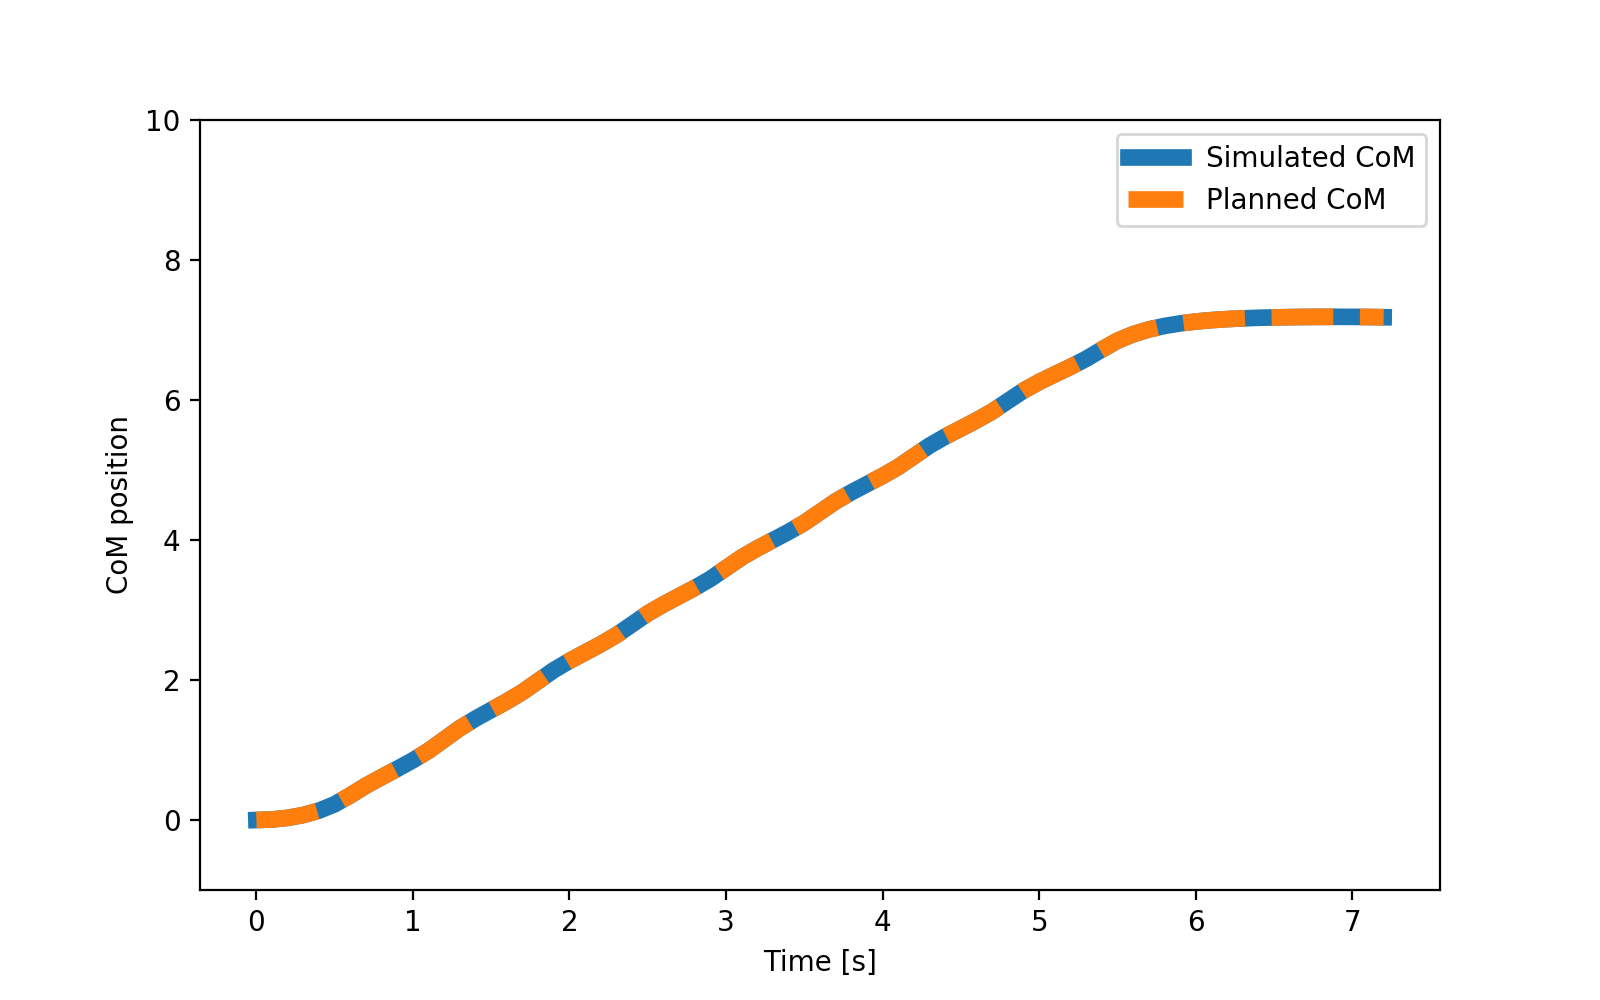

<IPython.core.display.Javascript object>


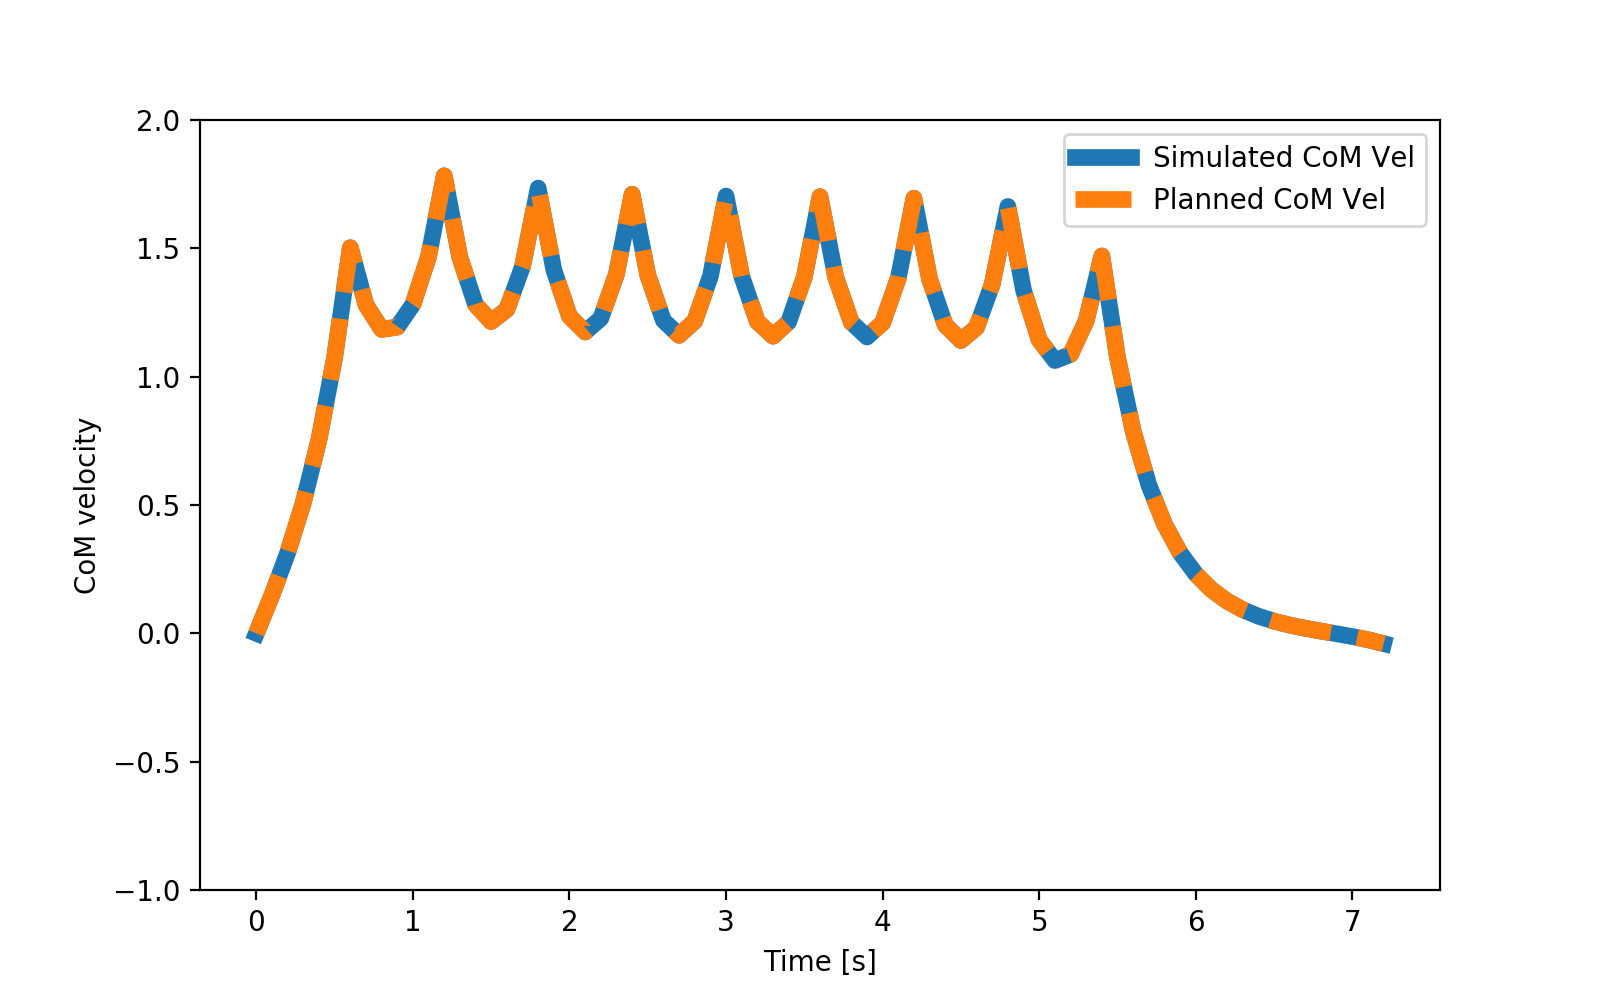

<IPython.core.display.Javascript object>


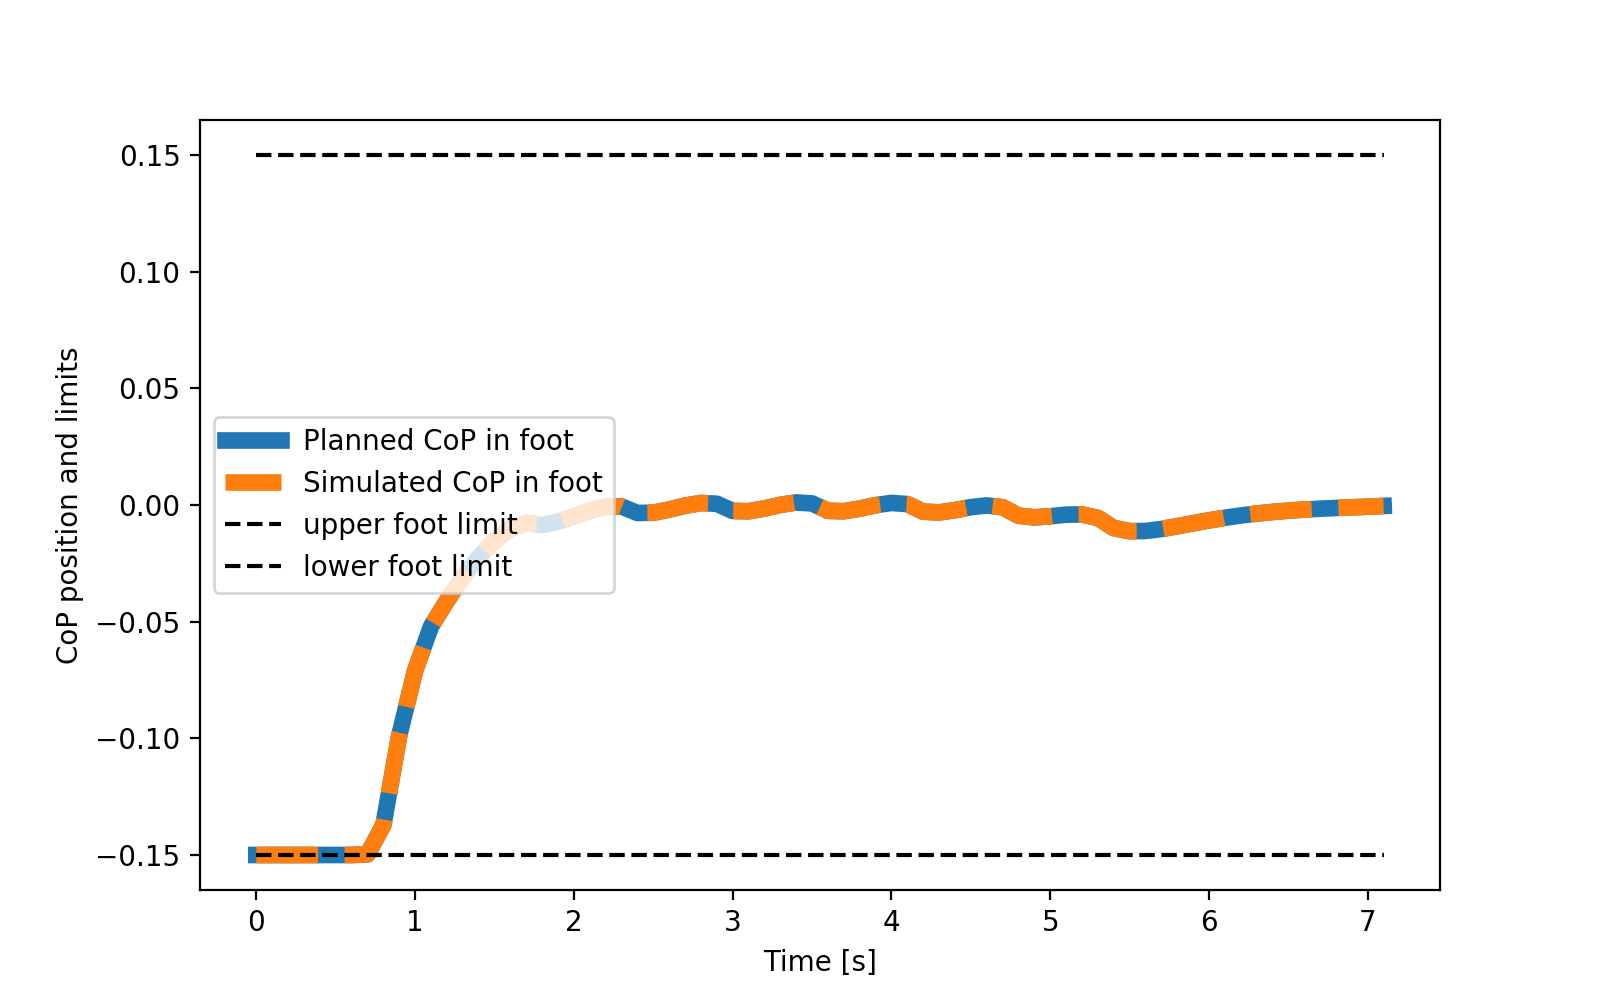

<IPython.core.display.Javascript object>


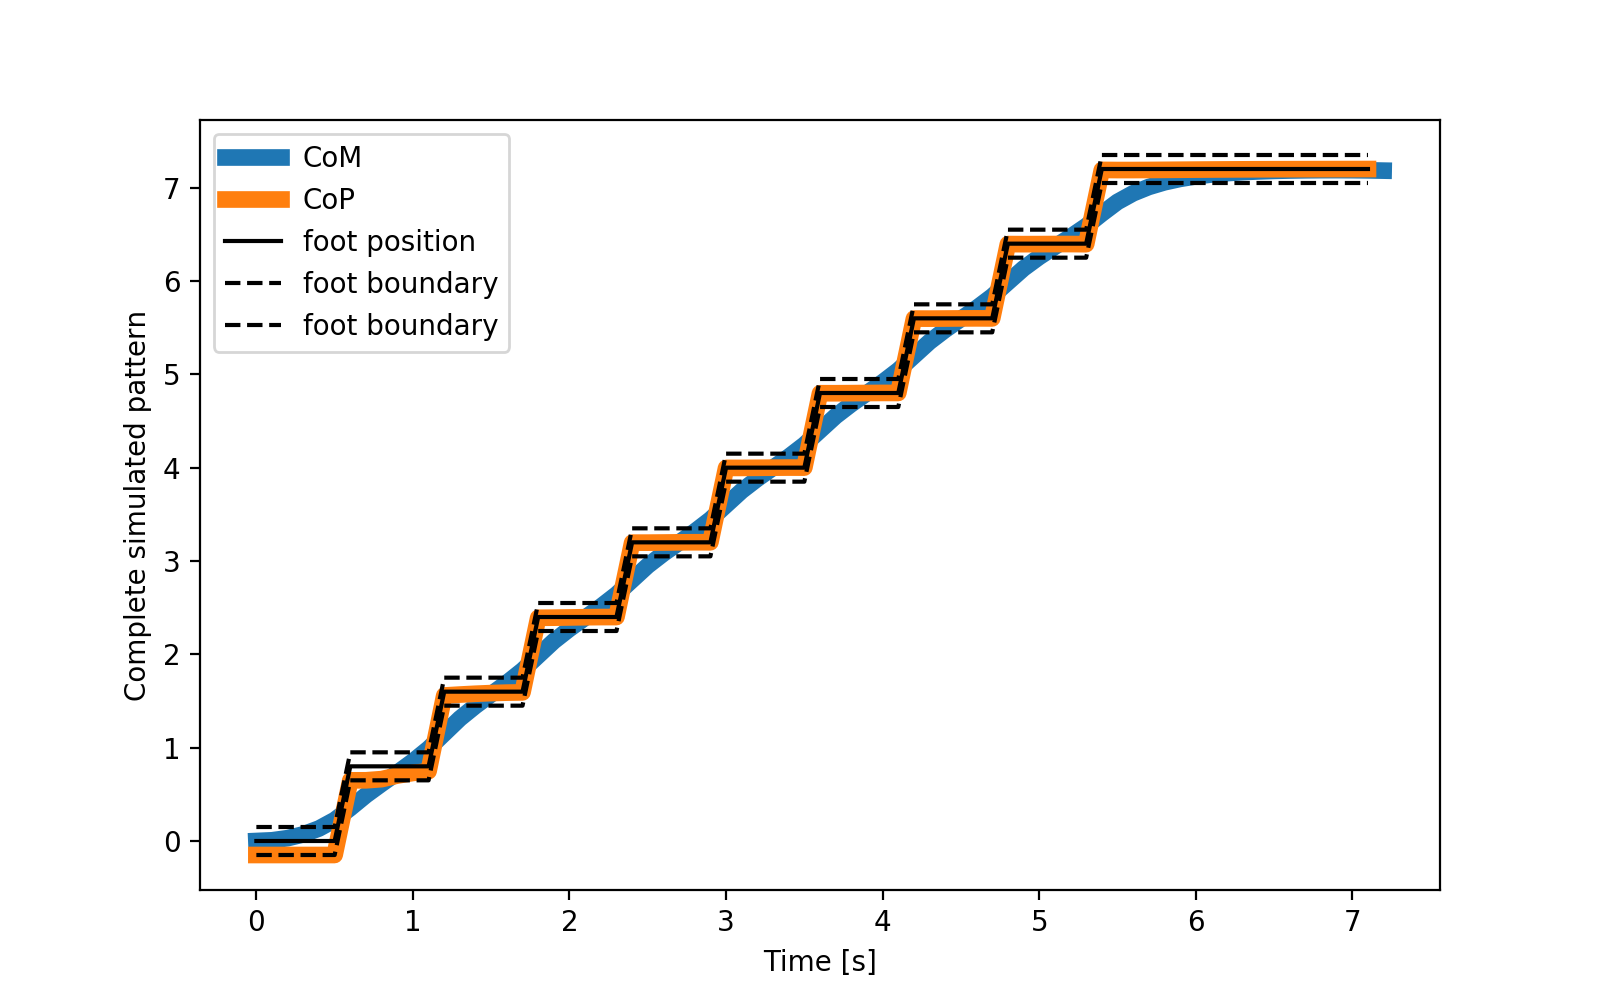

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABYjW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxhZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjpW1rX+nre3UiwZAQI9+S8/Rbtc1Uee
ZMiIvTZ8AEpZd2kWvIDkYIbh4wJqYr2vd8jziejNXstvyyuJwve38zcZk24V0ru8Pqco6IAJ6S2V
x+OKeQm6oXvLAVQaE3JbBeuy874HKmEhhJdnRNpqUe5Z6GHXDMYKP+87lS9nIcZdQVZxS73JUqO0
uiEF/SLIWOyt3GG3/D6vrorgYuSnHhFKIIykqTYlxFPPPhEq5cD4fXSeAco9ZY03sFACARTAILlP
6QUVPZkIJTJKQBD8CIDLppmrz4Y98jeOrJM7oIDCNOv9vnlqpt/l+dtvKkZDIWS79riQ9CkuPSwu
GoUBQ7HT+F0nfgWfmnOvF4LsE654rpBO/ohG3q+pvOnLGg5f6uYnzq+EfM5jGai9vHfbz5EBkVKn
bsEE7MRRgZsPhu9H+yDAFnjGgoEOTjR9I4LJta07wi7jWEUY4xUF/Wu5FSVJznZnWVQbSOeVq4XF
TYHQb8D2NwGQq3HjPZosMR+j8jcV5+qLmyFnr+m2U8iXeT3Ai3rBRrVgH2LOFk0yt0uZqVrNQzGR
Ff/758MmSMh1/o+budwZXBcZODqNRFWqLg5CxoB6ve5UQVq8cPKk4cPKu/kz9iuugOCHpbahrPF3
NfyItDAYx265738v0N1kh9FEJTF4098rmAyZb07yJ8/2DVUwJaxTy3ejxa3/E2MycBKltpvMu7Ja
79Qd/BS8Yyy9QCxhuUonRzkx8hOLkxxxhMKKrUj/61n4qdAXCpa6DCdpyxZWiWVkehyNhLfP6chJ
/5pEwtxShVdzDVj4qca9L0xVJBj35eVClwp+LycQTYW22032yU0IdwcOhQYkZaTuX9OWLLVCro90
W7n7wT+ktwrcns8b3wor2Z09+kXIIDOZxa0IPAqI17wME0EIBo2Ulwhdx77prDjorXxeglfu/6/L
NF2ycthyJ2FwhitW8aOISu1my5zPv9dINNqWJ6ToTcoCWiwXAslNN2scKoxXKYgwtm8J9VPi7bSF
DKKZtv7/3DUpdtauBrtPjBnNrP7cLliVVkcz0/4/gOIXfp2SmRT9V+A+VEIrvvtywhRSp1xljakN
U4mTefDPOnEhsMT8vgh7bpp0f6i5p1hqP1GU8TNAMC7bN9c/yiNQZokd1hW+St0D+YFxse/+o7Op
zYLkOfiV9y6XrHx0qT65VNwzb7uwA+yE2gaFPUlVsIBV7Cc9dlzAN4vRaaJOx6kZBVYjIzlh7bw6
YGnDUCoeaBK3rPrGL1glNeKEqmgxR/SSy8uh6igu/VLCxKWHB99jehwdh1mXu87gYi2aNeuKOLZg
Pb4uGQeTSz2uCbxYdWYngMHu/PutOgTLd4bSMId/HmOeWkS1RTXG99kUvX/TcBnxjPPx039T+ChB
QADOf+gzWW3WY1dZyDdEZE6u6str0JqAkCyWwsafkJVKyuc/DO1uv6PEWYV4u5xWPVS/8ww2BtrK
OnBDgCbEbNckPRUkvru6AOuqm//7PiKLQZpgr0IjBrnnflOsEL8Kze7HnG9RdOhefqK2BLY3WHTF
ixfAez3XpGRBwXF8wmCv6Tb+Mx5SdoMzRl9U1RiFhnOXn29d2Jc+/JdS2rXCQOSfC8t4Qu1cDw/c
60Us9rDv8OW4ocTpxgaNICUujELGkEByyf/eQEXvYjpxW/S3+/lKSSIKqEZfnaverqbb+wxz07Xd
QOI46tthEirhvrWhmK+/F+pLDcUjZQgr+dhi0BFJn7oVxvRzw5dVbv6DBdhLWeScsjWEEN+OZoLh
SZNhCh6AQtaIn3wOH3fgrbkP1bJWAywScFRuQUrH/eOtT6U4hxJHzmbDJxF/rFkUwrVPfSWNTRbp
hPH3naQKbY0qE73Vz5U/mH3g9yLX14CK+F92pUKORfwOK33yK91Wfu0Liu9QDpaJEOeBy430HKBf
SK6F11d7IiIvLD/Pu7x1DyCOo6iy6RrZOd95hdI5yA0nGlSPDSwSDNgriZoXsd2MXXZprZWIxQ4T
nlq7b6i3/yf9C6fugszH+4ONm1QQdd3PAkwiVJrvwBAHjgsljPOvdSU0pD2EgRYpV/Ui0j1YTdXx
N0FT1EFt8DG1P1Z5v0AGhb+27z/hAq1crHPAQuQaf+Ip8xi4TnFNIUgVUW+yuqKIq9yGdJGcUkiv
mXm6P2BWmX4TMOuInWYMARrPHQbVpzSaIcLPQnO83ZFUEJniv9ZKq09RH5yst+sTJaO1y802+rcR
EowV2T7B+2baj4N8xLKnCOtX+9DfGdnZGEYk3NV8Gwi1dtC20T2B8jyYwr+S6VM14TW2t0Ak/ohe
DIGh8jgIgDEx5EBmr6/URYhANGoyivvP7nv9wZuar/4w1GfD9E/OLKUPciOzzs3i6RkRNQvdQXX/
WV1pXOo+1NMt8wmOLwdDAlVk+Epc1yK4xeKqJ7WyZM8+3JZfUjesO8Sy5/mWmhVpIfOzm2Jbv7F8
6ynlHsMVCJghNRuF8rU5QfFkFeIkbv0lQRpOE5JJNtFesyDad8Z0ouXul7WaYXXSHn7be13muLDz
kIoiSNDZbdCC00eDrOPYjK0IVdXryUPZL1BLY+pmwcOw9j/GqCw97V+n8xZDapcb0Jrl3Pd2L6oX
LI25lhIN6P+czV9jLDaNC

In [7]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(step_time / walking_model.dt)

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)

# we now define a controller that will simply use the computed u as a control
feedforward_controller = lambda x,i: u_plan[0,i]

# we simulate the LIPM using the feedforward controller (no noise)
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=False)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

We are able to compute a plan but when the simulation has noise (e.g. the robot gets pushed or we need to account for errors coming from the simplification of the LIPM vs. the real robot), the plan cannot get the robot to walk. This is shown below.

<IPython.core.display.Javascript object>


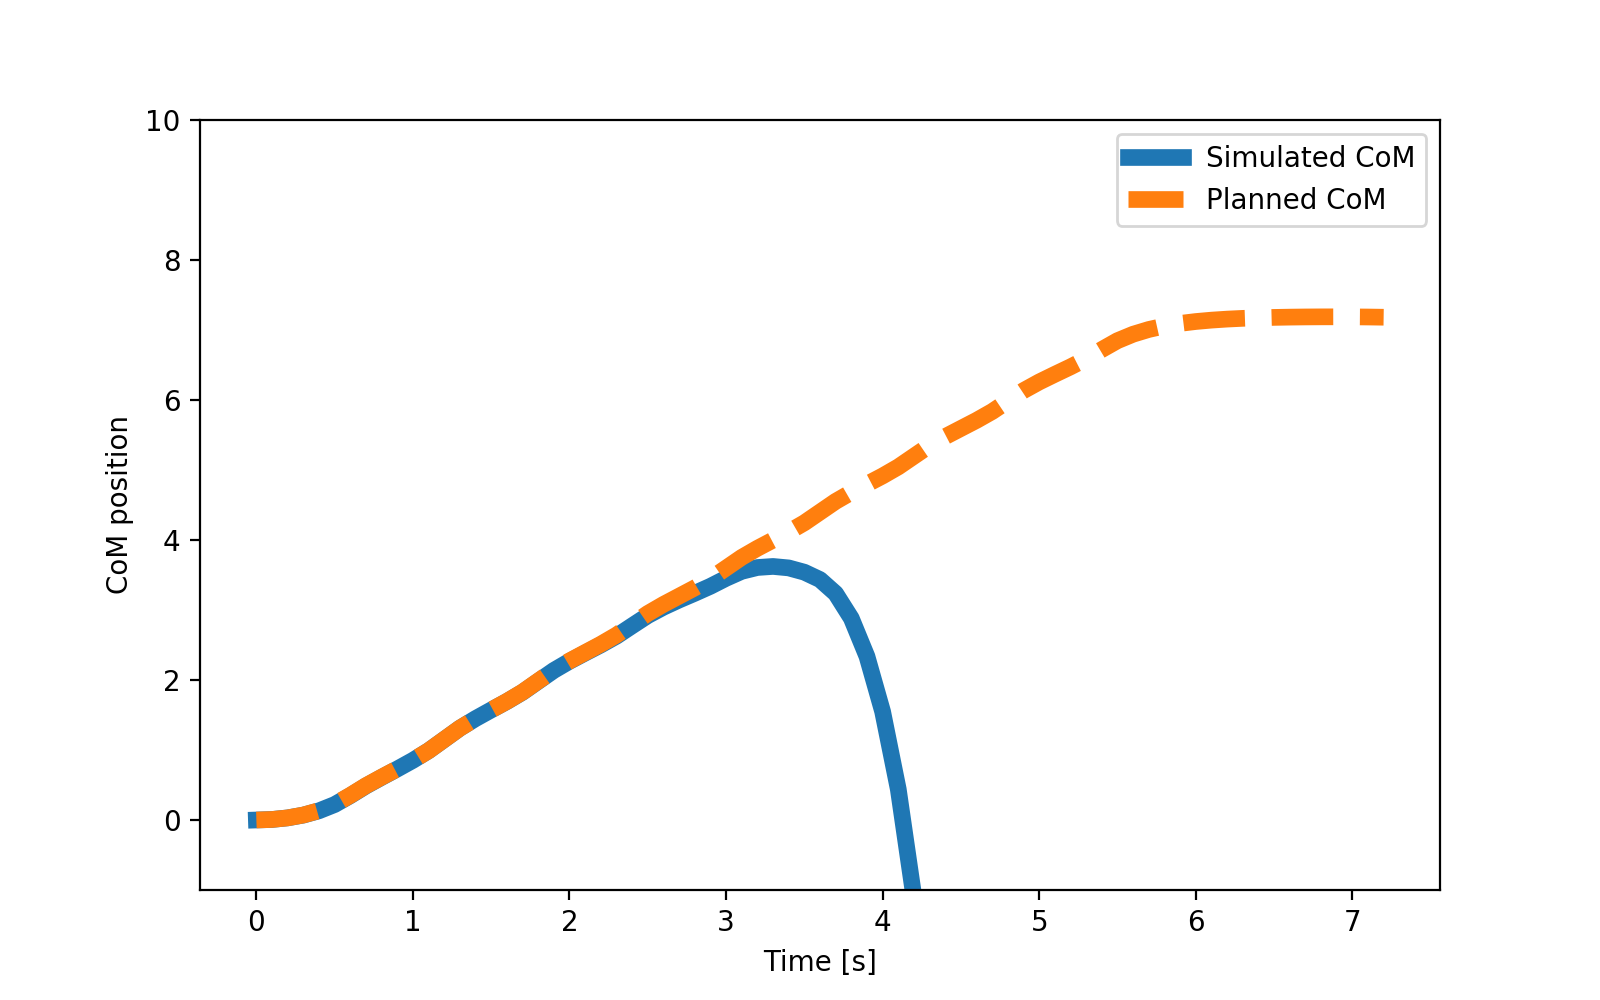

<IPython.core.display.Javascript object>


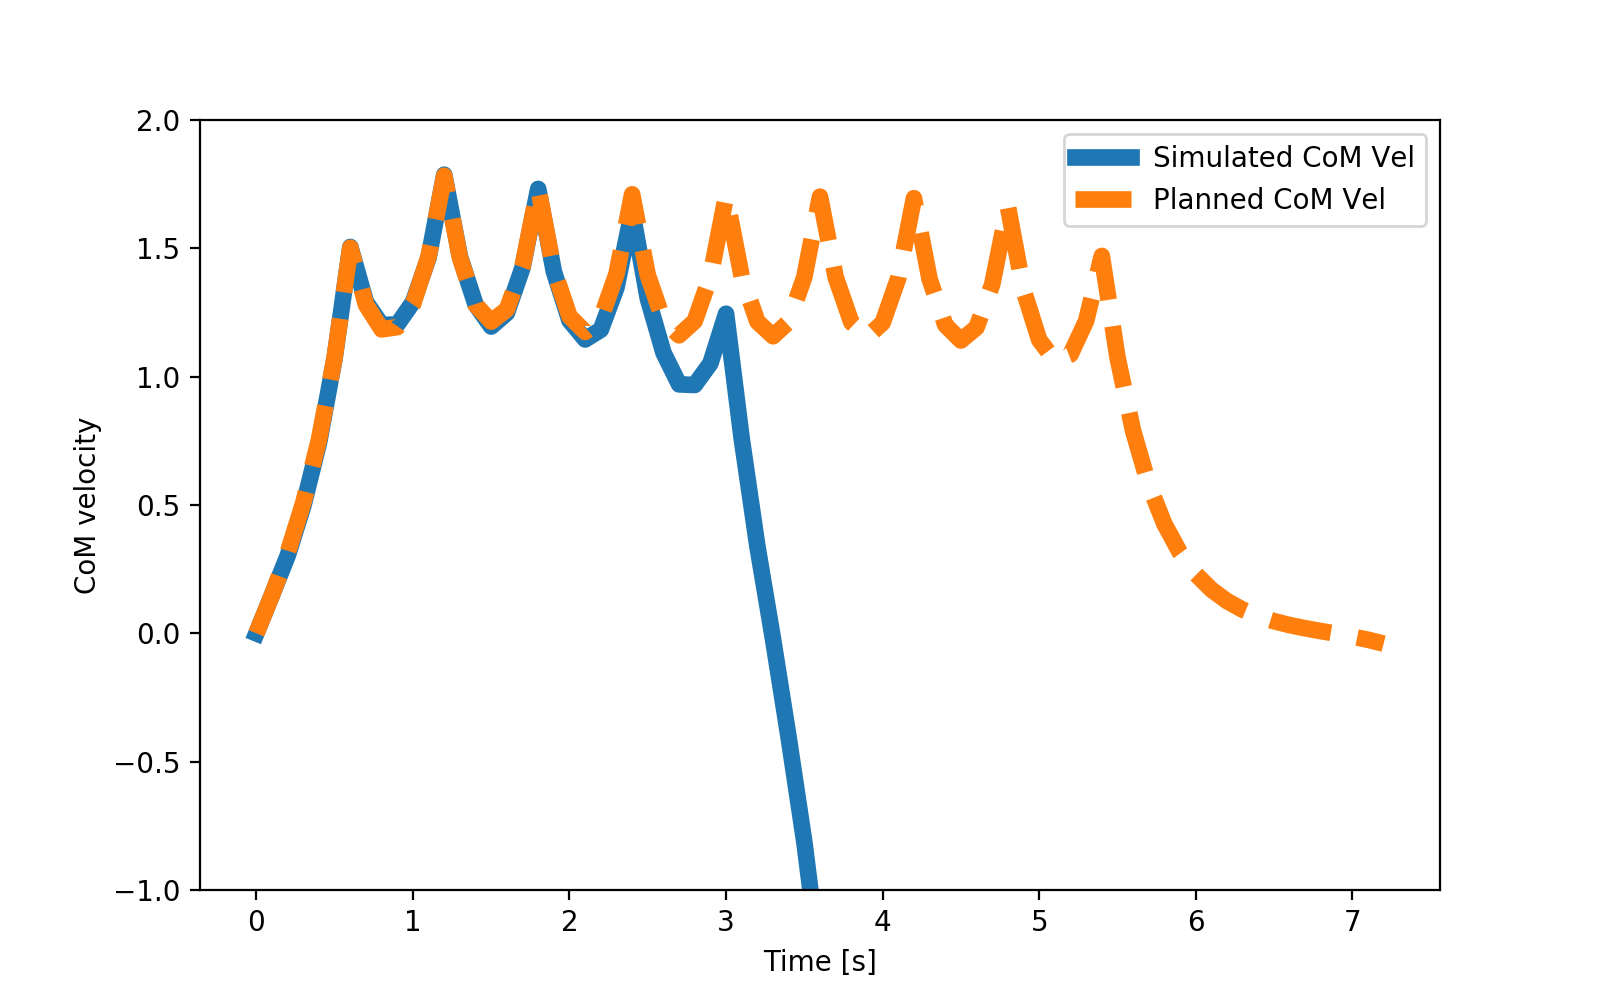

<IPython.core.display.Javascript object>


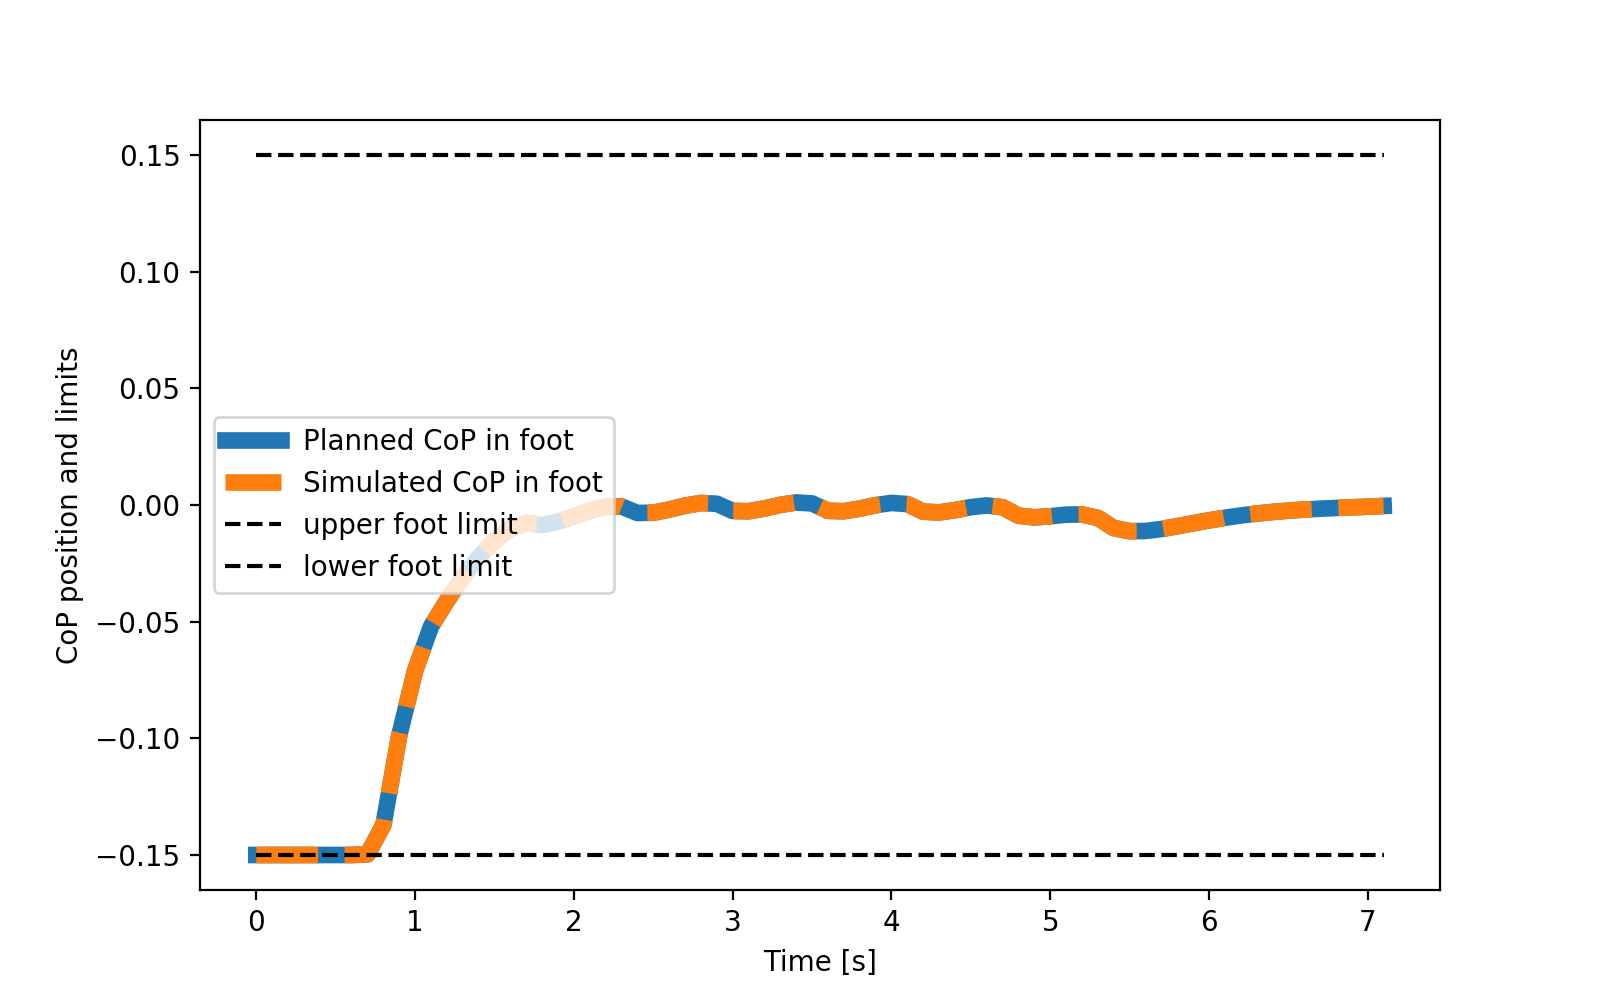

<IPython.core.display.Javascript object>


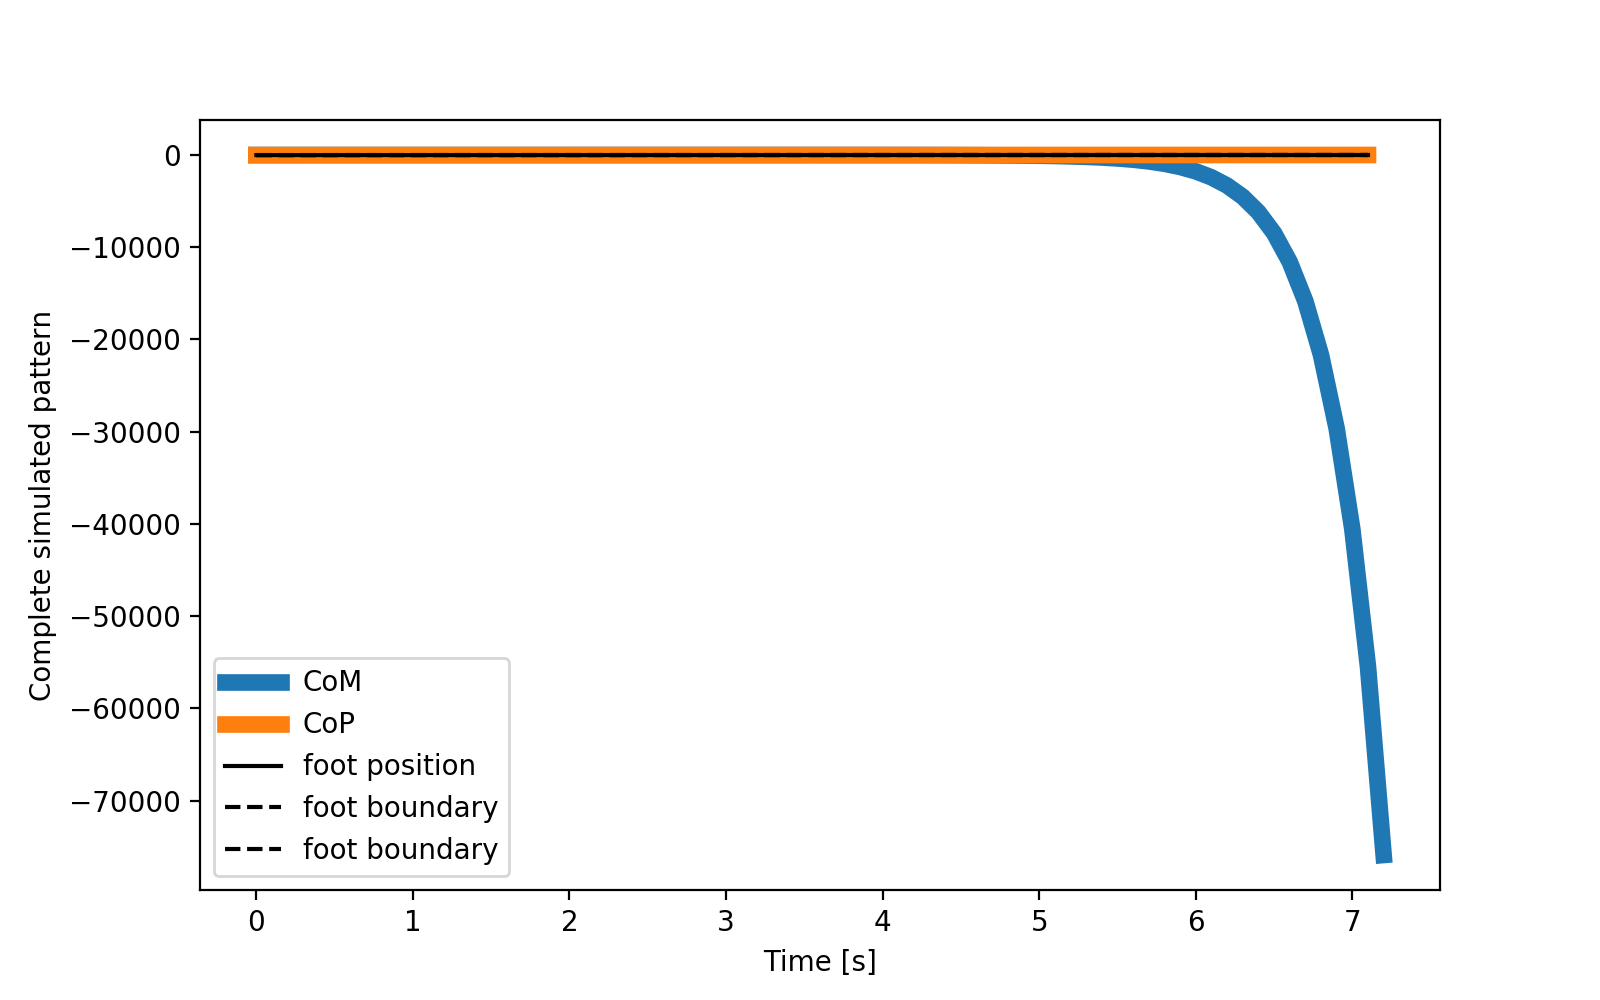

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABmw21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAyVZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjpW1rX+nre3UiwZAQI9+S8/Rbtc1Uee
ZMiIvTZ8AEpZd2kWvIDkYIbh4wJqYr2vd8jziejNXstvyyuJwve38zcZk24V0ru8Pqco6IAJ6S2V
x+OKk2fXnFLOveWAqg0OyzwCodl46nZ1jHNxEtf7oAyOCPeTkatxGgTVVX74iDtTEAQ2XOeqj/Gi
bjsihehaS8qUhbZMIBSefk27Z/sdF7Kwr7ATWDct+7nDjmWdLLiwqj3VhrZaErqNGzWrnSNhelDe
BpmzP2lAjS3V2WaSqlPA/0UXU6vvj3xI+8LPC3Gy3e5PdBAYUIrsdPriJ4anLvZqCimJp3CJHxD9
6AW2PdNJc9lL/Qst+L0c/yzg6CtZzg4ni8F2Cdc8dVRfJfF9eAVn5RuYWBTv0rVJwr96sJka84pQ
bOrUevhhSWfTt2CCdj0L6syXhu9f77e2LPGNBOm5jVhMTJ04gR6rMJmywlfbHB0JEVM0FCe03Rj9
/+VNKieOUPkukmEab3B0O9IsjeuqCZMngROz61w7YrEZEuAsg9c5UTNkC/KENKfW8/PLeXP/CuLh
gH/y2miniM5f0a81RSv40SaRQUPwwG/fdCScfXIji75eVPeB5yq/Dwkzk95Tpm8rK+IVqUkc5Psm
q1Vo5TFQBbkW1CCImrROE1vBh8+bMlRYIOt5P/+eHz07Indp891xmF0R+HFSIsoquheIxMxX5Qk1
zJaxTy3ejxaT8oKarCE28c5vMZGXh14wvg6VsXzuj6tphbio+Wvkx7YOwu5rWmJrpXnZ/FofKsjM
T/g8/m9b5xDrqo6i7CGGwlvn9OQlD817IW4pQqu5hqx6aINlEw5y0gx78vKhT6hWtk6l3rROLBFh
jbTARLMfJSvof6r+gqsRAhQ9Wo90W7n7wT+ktrzbHs8b3worrPzOFpd172jKJfd6d+9FUtYYJoIQ
DReZLhC7j33TfKiVVbfNNd8yqKQoW0iXOROwuEMVq8lTR7+3Di5njCLmknGYoeT0m57LaTR7o3a+
qDUonKG+KBULiIsZGb0rmcVn1JV6Tfj9P/AH1bN0tiv7uRdtGezlA5O+xT1coSda6f/VniziuiOs
cJYNOLBVPFW0+/+cRamqikUxnDQJMr39T3wCxRWhf1FKidoHWlmTEB9GA56SejDNsnZEeCpUNta8
T2ETl4cd5gJpsVVHz3jGYWTxL3TZ3oYhjrHKyvuXS9Y+OlSfXKpuGNg5dmDufGLyJ6kqbfyKjWtX
DGiAY6hTyMo/6pdQ7KsRkZyw9t4dMXv+NPHPNAlby0WMXrBKa8TLIcgB7LVCuEfBma+ZUJHkgmvx
+57NXOAyKD/BunZDhquVMoPaB0tWMpEEQJjTPa36t0WAmoGAwe79gJaGWiwnOExtuynJWx5Hs6Yl
7llUQMUer9Kct++M9ZrN3uAO1+y+Enic319Vq9CRH8890WRNlBFX2vQHBr+V/XyN5rbhQ87Qe7h+
SClEvpS6f1IbstDdru2ULCbSCGAb7zDoQ1IBR8R3YAuJz5Wu2LJuKG/AvzPCQ+/9II5hSYvMaW2G
7/hHa3BopHQ8CMxVMGFccayGLvsEtKc9q70s28/scylfdTr9cnQ5AP+2t2mgmDjFzNh2Kr8aw2xh
x0tH53UA0s6cLLXSyYHDglLgYutSu3kHe8KK2LVboHthz3sVouxb6urDXZtICUvAZ3OpY6skO+fS
6BfJfHrFDitJFiytk67+IjMtEIKWzd5wHeKhijM8dy4c1erbYRIq4b61oZivvxQPiCoX0mkkfQ7v
Q68553iQqoCp8uXKG26cCmKOX8kvwQxrr6VJgYvc+O85cYLxAY/+Kk3NJ01avrmFy9srL1A881OD
kFmPQc4WED9cKaHEVznMqxU7aS6Kh/LnJYXkJ02IRGjVSbN3Dr0OMJe1K1TqSP9odfO2jpbSBBEq
L8mqmsf6x8p1CB4hLiWNRItA4TG7qv3aNEl3xvO9RrjbMRh1zLvTHpGDJFXEsPeumGDztfm0y+Rn
FORWh6i5BMzy7IMAfVlyfL4EHQlkxZyAzsV6Jm7sYuu2f+B5aMjeiMY3Aloi0nlqT36GFHGwj/C4
2bVBB17WMtFb2LpK+WJMtqeF2dYUEd8UmBjOJAixSbgDjTBzyq2uH84/VzfT24qnb677l2/jtd4Z
wmn+vu/6LXDhb1jYz/6xS0q8TQ5dzOjqiH1MKYvuwRyYx9iyjVA1p/f4kgzzHTS+VlGgQs6zq9oR
TlqLmHE+bKEVIL9gP4MqEoG83Cvi9M3QNnFiJl017z9NTUNar9xfdMMGpjDPSQ+5zReuZqfK3rJK
JU9BqIDP8oSgeK064SZ53JE5FJQRxqzrW+THY0qf3JD2eBSevVyTPhQZBeWXhgCPbujA/aTreSLr
5cV0Y/GdG6eLjUAK2/SbQbVXkTelXR0YLB11Hc7N4ukY8VMQMeaP4YK6JNfAKY3aG+Yjld4OiO7i
8xtkua5FcYvFUtQSromefbksvqRtAftvuyb/r/83/xrvi6+vxIvFmPYH5R7DFQiYITULraw1gaD4
sgrxEgpVkqCNJwnJJJtlvU5fNe/DZy8CB73abTC66M4e7Q2n5iPmGVpryFG2d3SiC00eDPOmOwR0
mJ7PoKJW0ZcIz4wi2QcOw

In [8]:
# we simulate the LIPM using the feedforward controller when the simulation has noise
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=True)

plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

## Questions

a) Using the example above and the OC solver, write a model predictive controller that re-computes the optimal control at every instant of time as a function of the current state x. The idea is to solve the original OC problem for a shorter horizon and apply only the first control and repeast at every iteration.

b) What is the shortest time horizon that you can use in the MPC controller while still getting a stable walking in a noisy environment? (the simulation is stochastic so you may want to test your algorithm several times to get an "average" behavior). 

c) Relate this horizon time to the duration of one step. How many steps in advance is it necessary to plan for to get a stable controller?

d) How different is the executed control compared to the originally planned one?

e) What happens if you change the weights in the cost function? What if you increase the terminal cost (e.g. to $10^9$)? Can you decrease or increase the receding horizon length? Describe qualitatively the behavior you observe.

## Answers
a) Our MPC simulation relies on the following two functions. First, function control_cost_test returns the involved control costs and parameters such as Q,q,R,r, G, h for a given planning horizon. It is noted that we require the robot to stay where it is, once the end of the planning horizon exceeds the terminal state, i.e, we use foot_position[-1] as the desired state. Then, based on these specific cost functions, function mpc_controller_test returns the control for the current state, which is the first control of the control sequence for the planning horizon. We actually rewrite the two functions and include them in the class LIPM for doing simulation. Here, with the following functions, we mainly explain our ideas and show that our design can reproduce the first control of the u_plan, if we set planning horizion to be the whole horzion, which in some sense verifies the validity of MPC method.  
 

In [17]:
def mpc_controller_test(horizon_length,plan_length, state, stage,Q,q,R,r,G_bounds,h_bounds,walking_model):
    """
    This function implements MPC  
    Input: horizon_length: total horizon length;
            plan_length: planning horizon which MPC uses for computing controls
            state: current state serving as the initial condition for MPC
            stage: current stage number for determing the remaing horizon
    Output: a control for the current state
    """
    if stage>horizon_length:
        print('Error')
        return
    #if remaining length is less than the plan_length, then the remaining becomes plan length
    #if stage+plan_length > horizon_length:
        #plan_length=horizon_length-stage
    
    # now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
    _, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, plan_length, state)
    
    return u_plan[:,0]

In [18]:
def control_cost_test(horizon_length, plan_length, foot_position, stage, walking_model):
    """
    This function generates the control costs involved  
    Inputs: horizon_length: length for the whole horizon
            plan_length: planning horizon length
            stage: current stage
    Output: Q,q,R,r,G,h 
    """
    if plan_length>horizon_length:
        print('Error')
        return

    # we can construct the optimal control problem as follows
    # we will define bounds of the form G_bounds [x u]^T < h_bounds
    G_bounds = []
    h_bounds = []
    # the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
    Q = []
    q = []
    R = []
    r = []
    # if the end of the planning horizon exceeds the terminal state, we use position[-1] as the desired state
    if stage+plan_length > horizon_length-1:
        foot_extra=foot_position[-1]*np.ones(stage+plan_length-horizon_length+1)
        foot_position=np.hstack((foot_position,foot_extra))
        
    # we will fill the lists for each time step
    for i in range(plan_length):
        Q_nominal = np.eye(2)
        Q.append(Q_nominal)
        # we want the CoM above the foot and 0 velocity
        q.append(Q_nominal.dot(np.array([[-foot_position[stage+i]],[0.]])))
    
        R_nominal = 100*np.eye(1)
        R.append(R_nominal)
        # we want the CoP in the center of the foot
        r.append(R_nominal.dot(np.array([-foot_position[stage+i]])))
    
        # we create bounds for the CoP location
        G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
        h_bounds.append(np.array([[walking_model.foot_size+foot_position[stage+i]],[walking_model.foot_size-foot_position[stage+i]]]))

    return Q, q, R, r, G_bounds, h_bounds

In [19]:
#reproduce u_plan[:,0]
plan_test=72
Q, q, R, r, G_bounds, h_bounds=control_cost_test(horizon_length, plan_test, foot_position, 0,walking_model)
a=mpc_controller_test(horizon_length,plan_test, x0, 0,Q,q,R,r,G_bounds,h_bounds, walking_model)
a==u_plan[:,0]

array([ True])

In [21]:
# simulation with planning horizon =20
plan_length=20
walking_model = LIPM()
x20_real,u20_real=walking_model.simulate_mpc(x0,plan_length, horizon_length, foot_position, noise=True)
animate_walker(x20_real, u20_real, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABZhm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxvZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjpW1rX+nre3UiwZAQI9+S8/Rbtc1Uee
ZMiIvTac6Cqb6IQigN+xZv6HX0G1VgZK+kT7deZQiomYYxVX0xC3+iuydoEsMIOX9TlEq7D3Wmsl
LMONJXwFOdCbvLAVQaFokwBUOy8dTs6xjm4iWv90AYu2Szczs+GG01TE7d0QAKjoCSxr+eAKON03
HZFC9DILx/jgUZlHyNi0HHz3hZFoQdk/terB8+AsHm2I7x6gUPQkqGIne0bi+R2QkJ6+YT/D8dsZ
7DabjU1MzGiNTUv6rWFIs5PtN4IQKUioIDxQ1SxACvwqCAwoTkxHa+lTw1OXezRVFEdcc8yRCpN0
byeYrdRpMOUpxNxW9+CHyzg6Ivk34kbxeC3XsLnjENzeVQTFrb1kCzRDP6mEMOv3g8BAFxilLA+Q
9cLE6gm7PLn2+XnLnSxG+pHw3fd96BYVRBfgnTiqcTIkmTHtdTcRTmr9Br1OzqREGMcGv6L/3lR2
PpcDWTcLIRG40ZlhRav97w3JvUt2sMue9kz2hv3JsPUj7wtTvAJDoa1QdvGhwG6GA6/tkEhPSSyG
dX9t45CY1s4H+P/PhkyRkOwLEbuds6a3QX6D7ZYFPN1sjY0p4/eLB8RAKAKAIfbqjVFqPOTehYmq
YxqGs8w0b8iLLoDyW8OFUdjwNvem/xnTUB9GmS4BTeBVKfAekRWU8t3o8XZ2mMwMnASpbabzNjr5
aUML4Olyh2Mx9W0wtxUfLXyY+QnFyY44xrmiYde/hxPWbbFkKLWhyyt84h2DvZlrkhhsJb5/TkJb
kf3EUp1qchhOvseriDON8WctIMe/LyoVCU3TDNdl5VWuioNKWmJzmesOKjEjLSdy/pyxZanYRHui
3c/eCf0l0KNP8NPqjCivE/M4Wl3XvaMol93vuewS8t/uGM+sfPR9UFHzPoeABGLg7rao44CAIUZn
xhlhyJ2FwhitAv70yjyMzcNqaZ/F2nwnTYFB/sp8sYHx31KD8Uf2LR/n+fWXalLgawxQMkoITXEf
xQL6lSV6Tfj/n3s3aCXLXm+LEhGELH5skA2Yoo9G0wzoo1/g9//1mge66DEcxSsOY2FKa6vYAQLc
CQ2uiyQHaaX1P4w/GapjPChLxqaUVzrEfIw0/PjYGeZ1crez0BwIaGq60Znv8ryoePt5OH4P0R5+
uu3+wz3iKeAFoYgupIYkRZdL1j46VJ9cqm4ZPHnWcF/6EaCu8YlNj4kV9C7Qt8wDeL0WmiTt6M3Q
Qp8KT387bKOX3rdQ4qHgVyfpBf0Sm2qu6JlluyRQhIj3B/tQtfMqEjymzJKhpNmrnAZFB/g3iFhw
1nKmUHs+10IfUCQoCY0z2uEJCGPrMTwGD3f9W7h1S6fzV8gYKzrpc+T4EYS6JnHJv7kJ+9tiSKgq
YXZiWPuwMa+oOnP/QZrLbrzuZAjqj/kZxp4NZpeb7azLYQRJyqw8afhD212Jl7Y0Xs7A4Gw+kx/W
4zd3GzgAkNIvMHNgOlQ3j7dhVgbKIrZAPds0vEn1n0CT2AWE1nvjQTN6DDzC4AetvEcpnQmRYkoA
zJmo/fcfinVKJigvkvaiEgvPYgvwZbICDM1wPrkfcOumqMQdaLv3+Gk2niPqUkFdqUjMHuxrmYf1
RAm2rQ962iWe1h7X897FaLsWKyXEUYvSAlLtQbao7pNzjH1++AH8d30gUukzer+WlXXfx3CyDXBS
2bvOBLHmJRWJhllMdW2wiRVw31rQzFffiA4DqvvauwKpvg7hbSH3DuwAI8tIu94zYfvNaRh5MNVN
LW6KQKfFMUG//pHacce66wwVL2wTIxym1EW3rEy7JAIBk5gMxPC/dwJwdi0BiPwD6FOG+N0OMVRL
jYkN/neLzkYSSEPvLRlZlTIq4yUp7PrKfBNGQs5SDTQSXzVZULm/PKDkpaT3RfXgIr4X7By5c2Ct
gzjHKAD3VaT4BgZcV3a6W76uK73/C+xu2K+TbrH74Z6nWIqMHW07deP0KBUctUBzRREUyTl4gaSw
WHa4E8q5MiruFg2gjKIpg+LIzx8FjXzIcBV6/7/6xESgTMhbu+ELMx/uDjZtUEHXi78VMIlSa78A
QB456K7OsWNjJb2d/GpU+UqUFnhw4iiq2uH84/VzgS5AwyfzuWZARspdmc9o2T9DmaBQFvb/v/YM
fRHfZiMAHr14EuANO7vKjHgt9g2NkiBg9tPI/tDo/iVIlFhZxQeGl//RWovpIPvCw4XQh2oKfg8C
S3j8NUofDIic3JLy362o/Kc1qnSiqlxLiBBXZPsH7ZtuQa70QchJ9xRE4B3fGdnaHY6zLEvvQWLx
dnT5dHCIZQ6L2NqcuOQAAAMCCQuUAuVmMiRzYpgtxol4GAgdoHRJZ9EUXnvgGt49vKEjR7LayPYu
Z9D5ygIOd2QphpYy64jFuMU7Za+o12+xkBd6896/62LlF3xgWtQu8Mgds0aLgY+ubAgRTJvy3Rq7
2krppskPgCdI6nKcKDP++faKR4iPDoL786PNxwr9tdO1zAhHxkNqmjWzIlnd1sSPZsFWFuWA6i7N
lS3MpMYsldrKnYpWva6s5nveIsUP5DBanklfCcBxysNC9e+2T7nYn45un0PVMdAKcejZV5xNt5lE
dK81Q1R4Z9dehf+rDpUD0

 b) After several trials, we find that the shortest length is 12. We note that this is merely an result of averaging several experiments. Chances are that the robot may fail to perform the task when using this palnning horizon. Actually, from our observations, 15 is a safe choice, which seems to guarantee the success. 

In [31]:
plan_length=12
walking_model = LIPM()
x11_real,u11_real=walking_model.simulate_mpc(x0,plan_length, horizon_length, foot_position, noise=True)
animate_walker(x11_real, u11_real, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABcLG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAyRZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjpW1rX+nre3UiwZAQI9+S8/Rbtc1Uee
ZMiIvTac6Cqb6IQigN+xZv6HX0G1VgZK+kT7deZQiomYYxVX0xC3+gTGih15E8OX9TlHS7D3WoPm
/HFSf3wFOdCbvLAVQaFokwBUOy8dTs6xjm4iWv90AYu2Szczs+GG01TE7d0QAKjoCSxr+eAKON03
HZFC9DILx/jgUZlHyNi0HHz3hZFoQdk/terB8+AsHm2I7x6gUPQkqGIne0bi+R2QkJ6+YT/D8dsZ
7DabjU1MzGiNTUv6rWFIs5PtN4IQKUioIDxQ1SxACvwqCAwoTkxHa+lTw1OXezRVFEdcc8yRCpN0
byeYrdRpMOUpxNxW9+CHyzg6Ivk34kbxeC94EWCafOjC5dOp9b1kCw7BFdNo08Jdlagq12U//pvH
5ydvOx75vWlJM3ciPUA/bcd4+iV3T5z34KBLkCJ1UGIwA5D4lcp5cufVNGhlgao7pBuP0P/3sPcM
fYT4xrdGoV8rht0HHZQS+/ymZx0osCrju4ZsQBdim9QCTJX+DBfKgm1qA6WfnziS1ft3s9YucfcS
3wMpYFE1jnnXIoBhWHx8bWw3qgVsIUA5rHos7fHXcSpBU3wu/79ZB0ioDPmFdUTYRWlV8k1FBN05
9iodkKsoNpf4eBxFNoVP6uIuNBD4KgH8h31F/u6u7myQqih+pigaW+RZRVdC7sEOyc1kggddzpWl
BDMEegOkFNVhCbeOc3l7sNvhDpqKbCHXjEPoBYw3KUTo5yY9sHYXc1rTEFH4PU/s0MaAgzE/4PP5
vW+cQ7A1E2fGHI2Et8/pyEnvmvZC3FKFV3MNWhuAjcJ70wvnkiLkwvfzr/KTUMONYtKATgp4KYKm
9TCNBa0pY8h+amqpiJoG94+HYYhp8FAL5F/Db6owornZ09+kXIIDOZxa0JCl4iqWsME0EIBoqNxh
vq18+XgjElK90dFbnxURwraiDr6fMhVwrbSOvaaXdw4eX4zpnZJxj0Ce17lFt1JO1P0snn/leqod
1CnvIjx8+6qECR5MD7UdbZrBpTwvpIe9GDrf/oJT2y0FO5dqWxwo41ILIUUHxoROQa3TqSoNnD2/
TAofozzwNLe15qxxL4BRDgZJx0abYP6Lxfkt24KcDrmQUKUvayMv2boXAUp6+tYvfo00WLS9g/AC
TuFwRHf6PfIN/r0cH1pRhXjW12pa9oCbsufczcIfG0cRIcaAvode9K+XfUzt+1LtRTQSdnipuSMv
eiGZqTAjHUKeRlIYHQ7frRa5yep2wIWsT418zqedoEre2mL37mon14oKXRoo+4R7nPSok91u+1Td
YqD7kAHBcLAp3L4Yb/uFpLlV2rZZ/LS6UoPb+bKWe1uQddYnz9c3p139x9Xf1UTwuO7H4LkrbUnH
lUnIRi64yo5Iif0vCrOzLW8i3sXS/JA9XeOkGjgT5p+xxlzIj30nvZnqHx3y2dxo9XHSe1LC7vHq
chBEwFi6ZMFIOk7rZHW9VMVpe0Avmw25yH+Ftk+uE6BAABF/hUjUL/EtP+7ufwtPZmXeE4urMig2
5r5s4swShT0P8AGDUoe9kB6I0daS1C80ZtYVQYer2CCUmWgVfpNvbp7x08B+h0X/PNNsnUAFP+cz
Y5Ur65L443R+s99Mo5yPoRRGXrKHp0avP6GUXfScv+QdIumGhMGjSAlLwsjPen0dWXT/Xak76Qec
DadAUIHJUkK/G08tqBSkBePrJVz/3PfTKncuHNXq22ESKuG+taGYr78Ull2XdKZFYswyz3zmzX3V
05P4U8ut+46KypSxyL4/ZbEFdX2AndIVWuSMmGjXqJIAWxU92heA3T+drMEF8MwjJLLmyCwjK9h+
9qLU+lOIcSR85mwGS5f1iyKYVqnvpLGpot0wrC10Wep1lfcDd1y/7GAY0Yzq8BFfC/FkwKBfvjxu
4gesInzgzw/nldfR5eMlK0jfiF9jdsV8m3WP32v4no66MHuHdxVX6FAqObMpDwURFMk5eIGksFit
L3DbpbRd4vhrE3k+x3YxddmmtlYjDsAq9f9/9YiJQJmQt5xw+j9cilgg2qCDrz+u4WoSpNd+AIA8
cGDcCkZJKHR2tw5hO+UqUFnhw4iiq2uH84/VzgPyLrvb622xQQrDth2opgV7eeS2oE9gMQdAf+4E
3ENrpiIS/shzVDQ8bwUmSjih+3qKCuFE9wMfmv+veDRF8rJRMlN1lhzViS7geq0Jk+9BqO641qUb
CEEjgr3Wh3Lo6luec4YGczM6s/HyCLvtkZ9CKoBSSD8csZPuHOReRS3nCOvWBvetAXDYSh6UXzOD
Sa1kNMSz9TLDGAPkeTjlyEJl6TElWbUYyBoPXzSvTVEQmZYwg68izks/CFtRzp4pzwWbkAeEk1EU
JGj2Vr/jBOIhrHVrPc7rku5dm8XSMhnwtgW19Rrt9jIC7167R/3YKKpTC6oTe+nXIIu9O3cUQ5pm
mjzJvy3Rq72koNE63fQBOkdTlV3Rd/aQNi7HkQ90A/tJE6mGT7bCs8eI6AI/DEvLiib7O7rYkfc9
oQFhEzy27J884tWiuwTobqdilbOP65MOToY0/wgIkgNxdB7T5BVXZP6eo1ZykGgx3dPoeqY6AU9r
S3ciCMX0fI6V5qhD30AQ2

In [32]:
plan_length=15
walking_model = LIPM()
x15_real,u15_real=walking_model.simulate_mpc(x0,plan_length, horizon_length, foot_position, noise=True)
animate_walker(x15_real, u15_real, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABcyW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxtZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjpW1rX+nre3UiwZAQI9+S8/Rbtc1Uee
ZMiIvTZ8AEpZd2kWvIDkYIbh4wJqYr2vd8jziejNXstvyyuJwve38zcZk24V0ru8Pqco6IAJ6S2V
x+OKeQm6oXvLAVQaE3JbBeuy874HKmEhhJdnRNpqUe5Z6GHXDMYKP+87lS9nIcZdQVZxS73JUqO0
uiEF/SLIWOyt3GG3/D6vrorgYuSnHhFKIIykqTYlxFPPPhEq5cD4fXSeAco9ZY03sFACARTAILlP
6QUVPZkIJTJKQBD8CIDLppmrz4Y98jeOrJM7oIDCNOv9vnlqpt/l+dtvKkZDIWS79riQ9CkuPSwu
GoUBQ7HT+F0nfgWfmnOvF4LsE654rpBO/ohG3q+pvOnLGg5f6uYnzq+EfM5jGai9vHfbz5EBkVKn
bsEE7MRRgZsPhu9H+yDAFnjGgoEOTjR9I4LJta07wi7jWEUY4xUF/Wu5FSvlJ+ZOsqg2kc+r8wuK
mwOg34HsbgMhVuPGezRYYj9H5G4rU9UXNkLPX9Nsp5Eu8nuBFvWCjWrAPsWcLJplbpczUrWahmMi
K//3z4ZMkZDr/R83c7gyuC4ycHUaiKtUXByFjQD1e9yogrV44eVJw4eVd/Jn7FddAcEPS21DWeLu
a/kRaGAxjt1z3v5fobrJD6KISmLxp75XMBky3p3kT5/sGqpgS1inlu9Hi1v+JsZk4CVLbTeZd2S1
36g7+Cl4xll6gFjDcpROjnJj5CcXJjjjCYUVWpH/1rPxU6AuFS10GE7TliytEsrI9DkbCW+f05CT
/zSJhbilCq7mGrHxU416XpiqSDHvy8qFLhT8Xk4gmwtttpvtkpoQ7g4dCgxIy0ncv6csWWqFXR7o
t3P3gn9JbhW5PZ43vhRXszp79IuQQGczi1oQeBURr3gYJoIQDRspLhC7j33TWHHRWvi9BK/d/1+W
aLtk5bDkTsLhDFat40cQldrNlzmff66QabUsT0nQm5QEtFguBZKbZiyRiCHAbU/cmfmKBMUd8jPr
o1LkcpKVJXpN+P0/6gDw4DQSWKnMdFJszYMZ049z2nCj/9Liwmuj94whi7hyfgX9VmlZeeaeCFG2
CiElrZ/7pxyRY1oFOJz8HgrBYlx8D9uipLrDOrlb2nXUAimkelx4/sObnZJFLdH+zoBuq/DzRgTT
PVNnehpGItdUbcy6XrHx0qT65VNxFmpDbsz+dfervGWbqGKK+hdoW+YBvF6LTRJ3IsB6B0UZGcsP
beHUnrqstqedoErelmxiOaifXiZag8atAwmKI9wf7ULXzKhI8oKRCoaTZq5wHZETlKNgnsHlYq6x
z0l6t3E82IEyPCP5wXYEHdLN/U4pvOpwqrDrumQ2dvp2eDP5UpPoF+9ZeFnrQljWJDo3vC9YttYD
a3KiMxks/vbDrRmXQwH74232Tsd6pAspmrNG5QdUQUDboQ45ubzVtmdP4yCDkiHyC4BHWjcNrQFE
TCVlbIB7rzoZAJZ49qssXCaz3xoJm0Ll7Bmj7pONyRedCZFiTwHXK40mrYkd7Q7fKgvkvaiEgvPY
UPwZbIQyfQwDzkfcOumqMQdZWn39TFK6QDDCymDII4hotIxxjpviBNtWh73y1QdrD2v572K0NZ6j
F6QEpev7jsubpoJUX+tzGX+7Qc5hnbSoAm/udyDuTOmeHS1DI2rcCM6ywDXHjuXDmr1bbCJFXDfW
tDMV9+Mh6ScyQEbMukKnZjnyN3NfGE46ZeqThPe/WtIYBgWhRVJl17hm5xJqisWevMlwtbx+Q0F5
AzAcuDS3rksTm/BW3Ifq2SsBlgk4K8XECQrYbTtPpTiHEkfOZsHh7lXa8QxSt6bh1IOD/giA0+ui
z1Osr7gbuuYBN//moz+Qb02zpbe34pHL8L7HeRiOBI4YesFK7dBcoHXX6wse7x5fvDSw/JU7jfQc
oF9IroXX7rhffCxYdI1Rb6/QoFRzlm4eCiIpknLxA0lgYlKUqeecLggzYK4pL+nkYk8ZSIwzS/si
oCr1/3/1iIlAmZC3ByX6P1yKWCDaoIOvR5jhahKk134AgDxwiCrah4RxDTUh7CQIsUq/nJhx6sJu
r4m6Cp6iC3WmcQ38zeVrd735aTRmNenZn4ryZgXR/7V+SHZUQ8oEpysUnv5eg+KofMCH7lOq/Ctt
kwPH/x/Z3BLTL8KGU/Ik3+u9I/24Sghxrb2uB9XxSs1d7kDJ5ueXRCE9obS72r6HE9C9rGBZcOxq
9i0WmNt+IZCXO8AZEuHY3+qzmrgxAZ/lCUlDfwREhojLI+3xqHRcYvQsB8jx/kPXlm4B95bGsAug
Tc1WgXoqGcYtBWQ/CCbJjtkKy8SScciie/XNXeBNGEpnloaOT6xgbEJvRxKapDezudm8XSMhbAvl
yUKGmOBzEE8F35Tf5+3yqvSXnPnFcMgds0aLgY+s6xz+kbqta8TugiX/MfLJ7o3A3O6UILz/tIGx
djyIIjianSPNxwr9thWhkoXovzpqmjXIluzu62JH3PaEBYPC0wGyfPOLVorsE6PtPYpWzj9c3do1
dXFD+QwWp3deg6YccrDQwnyvzOUgzc3bp9D1THQCnIYtlecTZvgA9RzrprsPb2KIbaLpLPL4O57u
0XLz89FFWWEg3o/5zNX2M

c) We know that the horizon length includes the number of steps and two cycles without stepping and iterations_per_step = 6, hence, the number of steps corresponding to the planning horizon is plan_horizon/iterations_per_step$\approx$ 2. In other words, the robot needs to consider two steps in advance.

d) The comparison is shown in the following figure. Compared with the original one, the executed one ensures that CoM moves in the desired way, whereas the original plan fails to control the robot. On the other hand, in order to perform the task under noise or disturbance, the executed one has to choose CoP locations different from the planned locations for stabilzing the robot in the noisy environment, which is very necessary. As we can see from the second plot, even though the original control makes sure that planned CoP is put into practice, robot can not walk propoerly with these CoP locaions, due to the disturbance. 

<IPython.core.display.Javascript object>


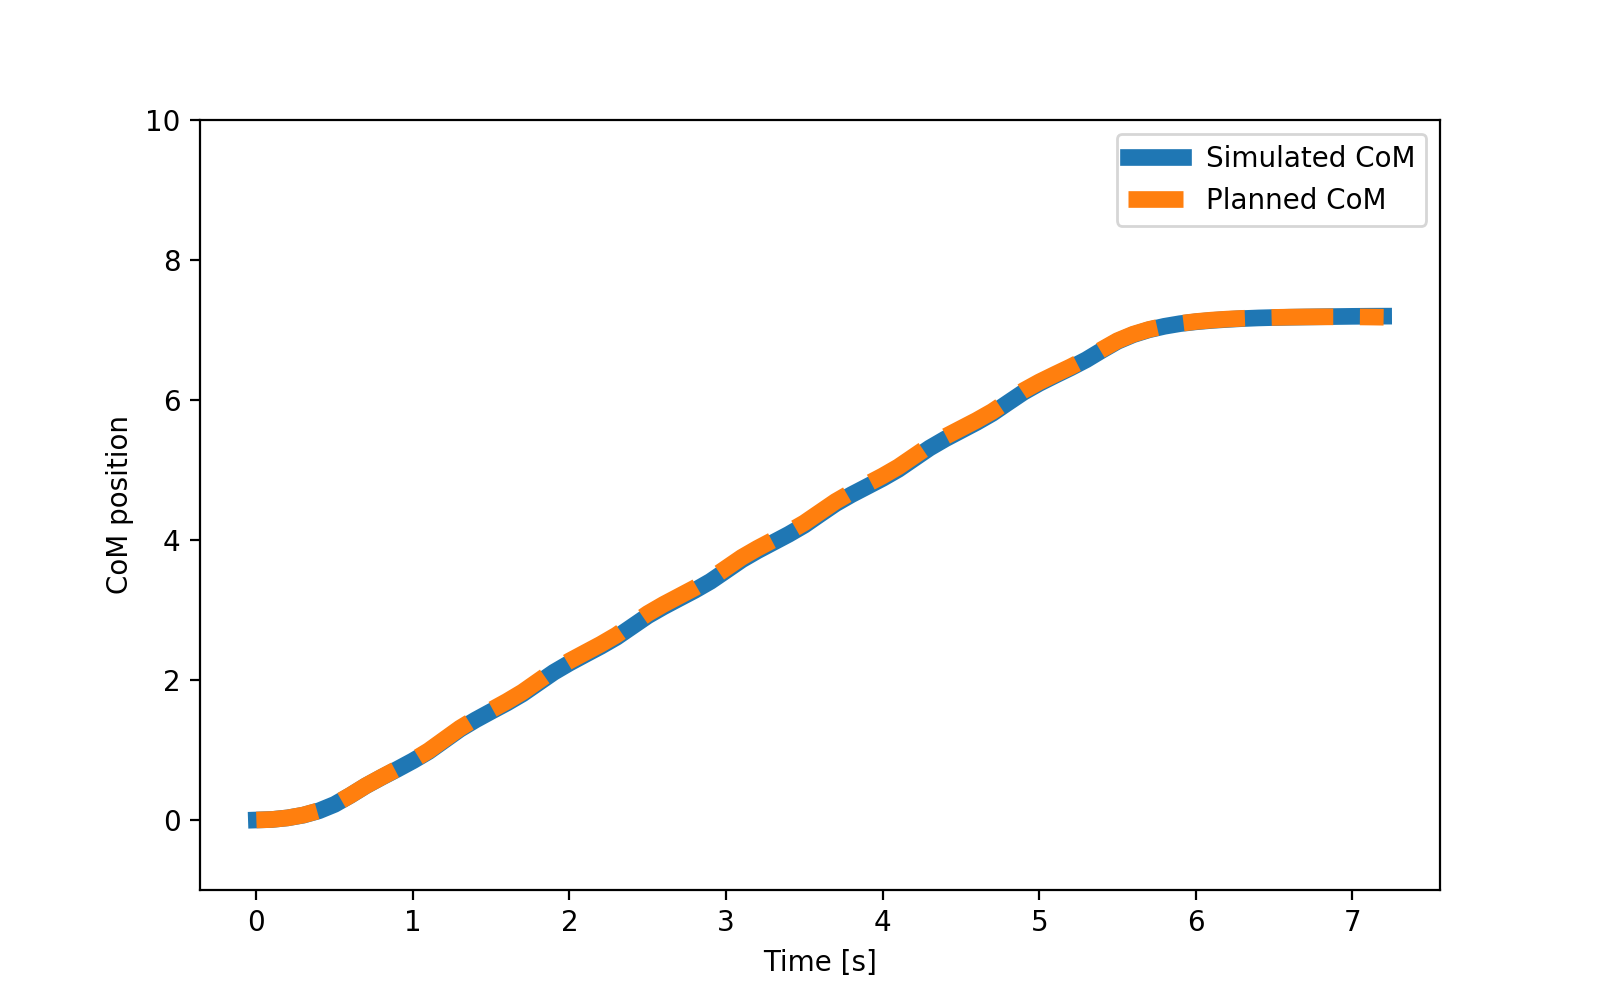

<IPython.core.display.Javascript object>


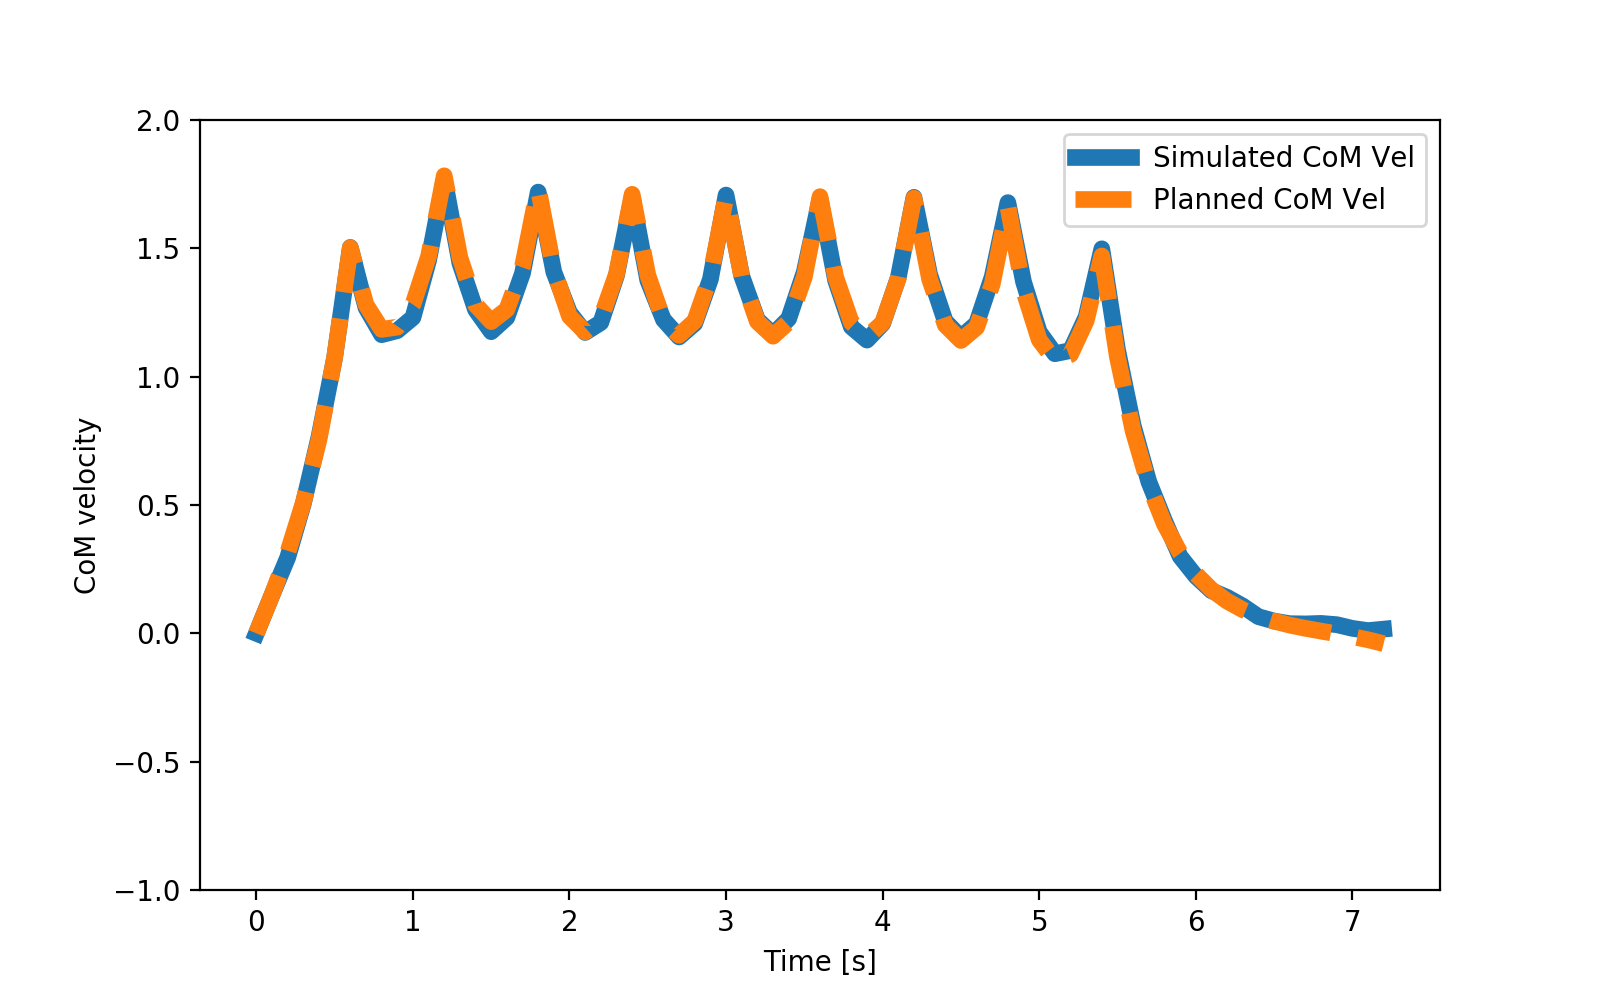

<IPython.core.display.Javascript object>


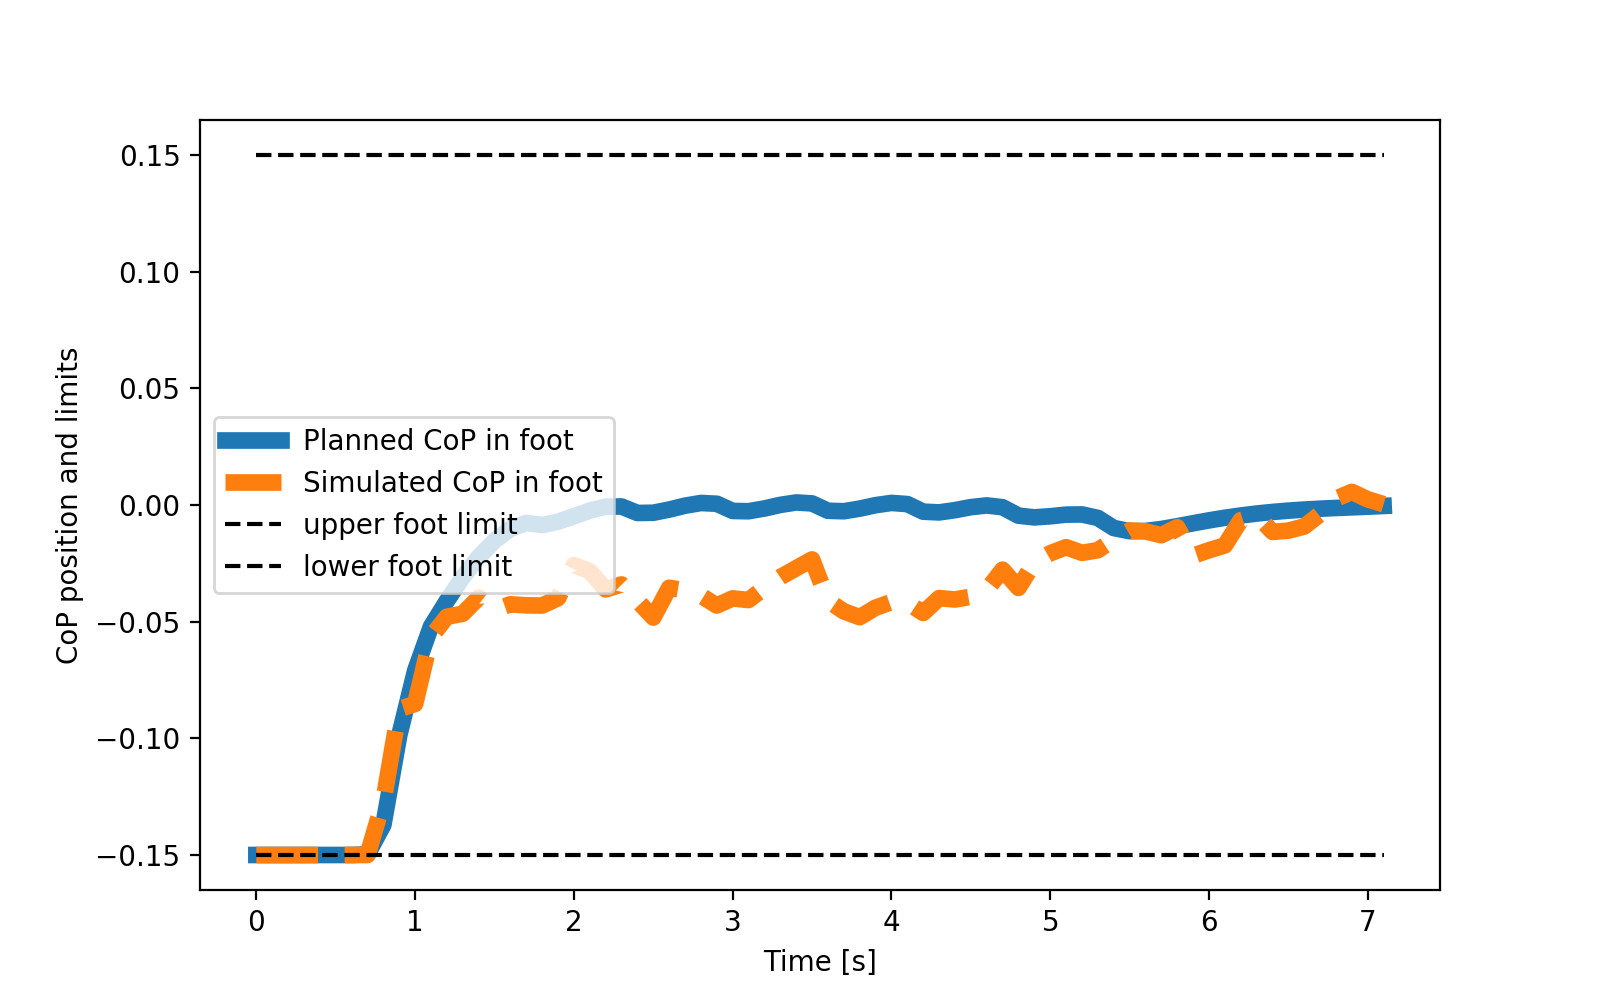

<IPython.core.display.Javascript object>


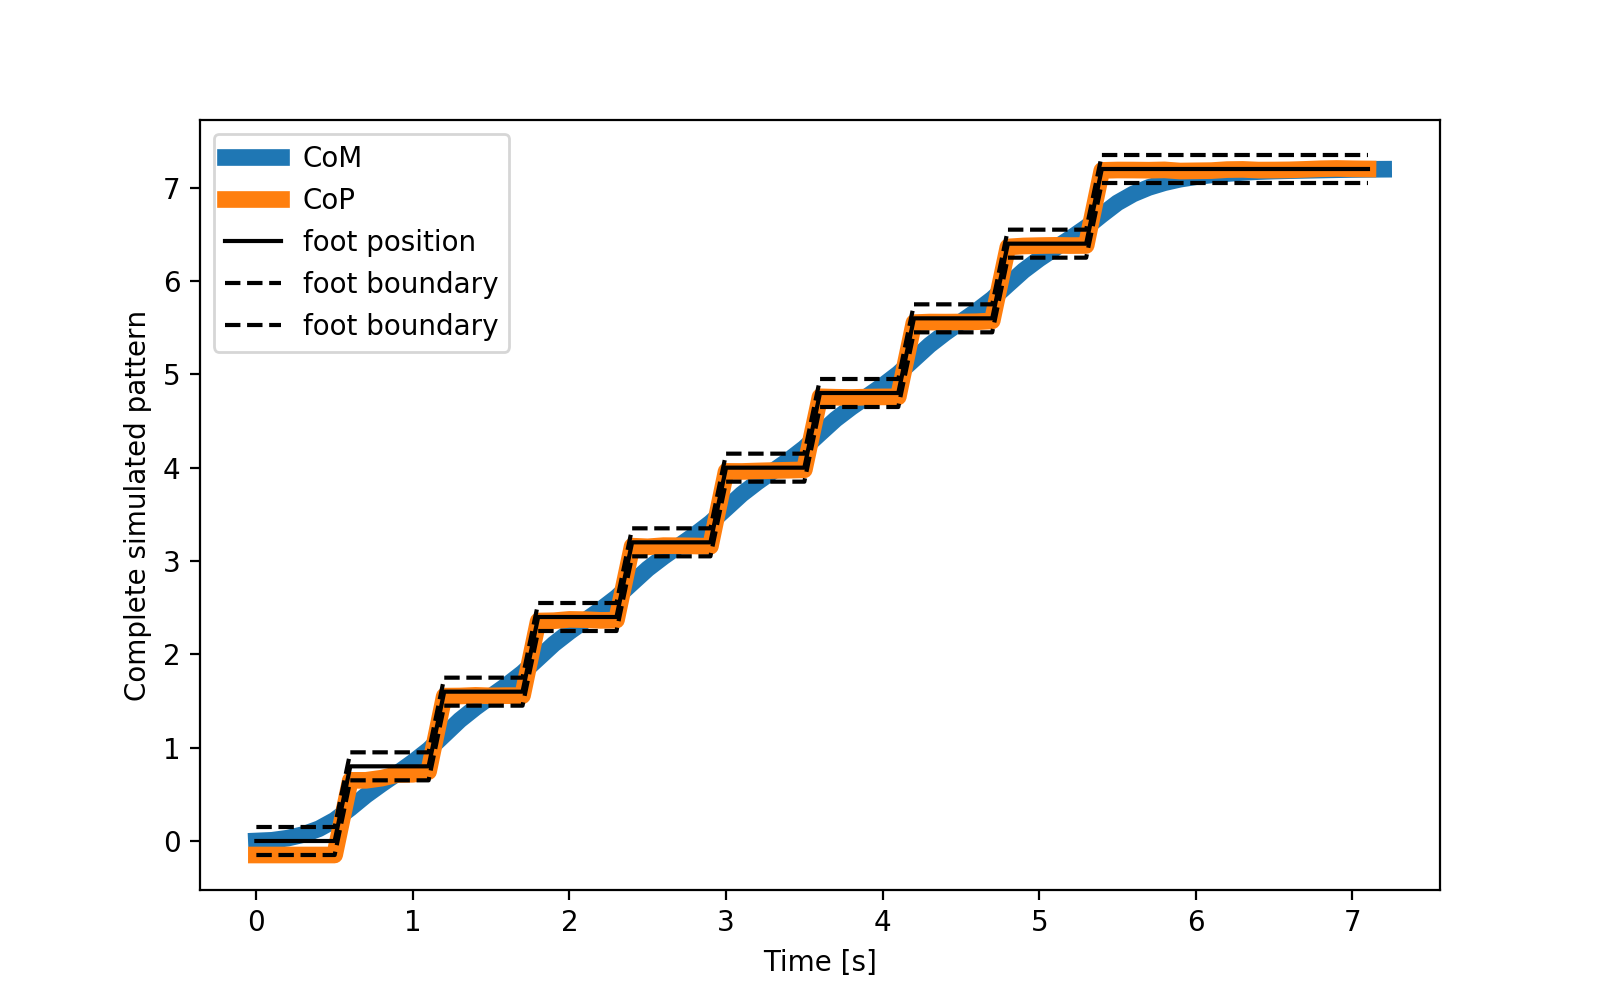

In [26]:
#the executed one with the planned one
plot_results(x15_real, u15_real, x_plan, u_plan)

<IPython.core.display.Javascript object>


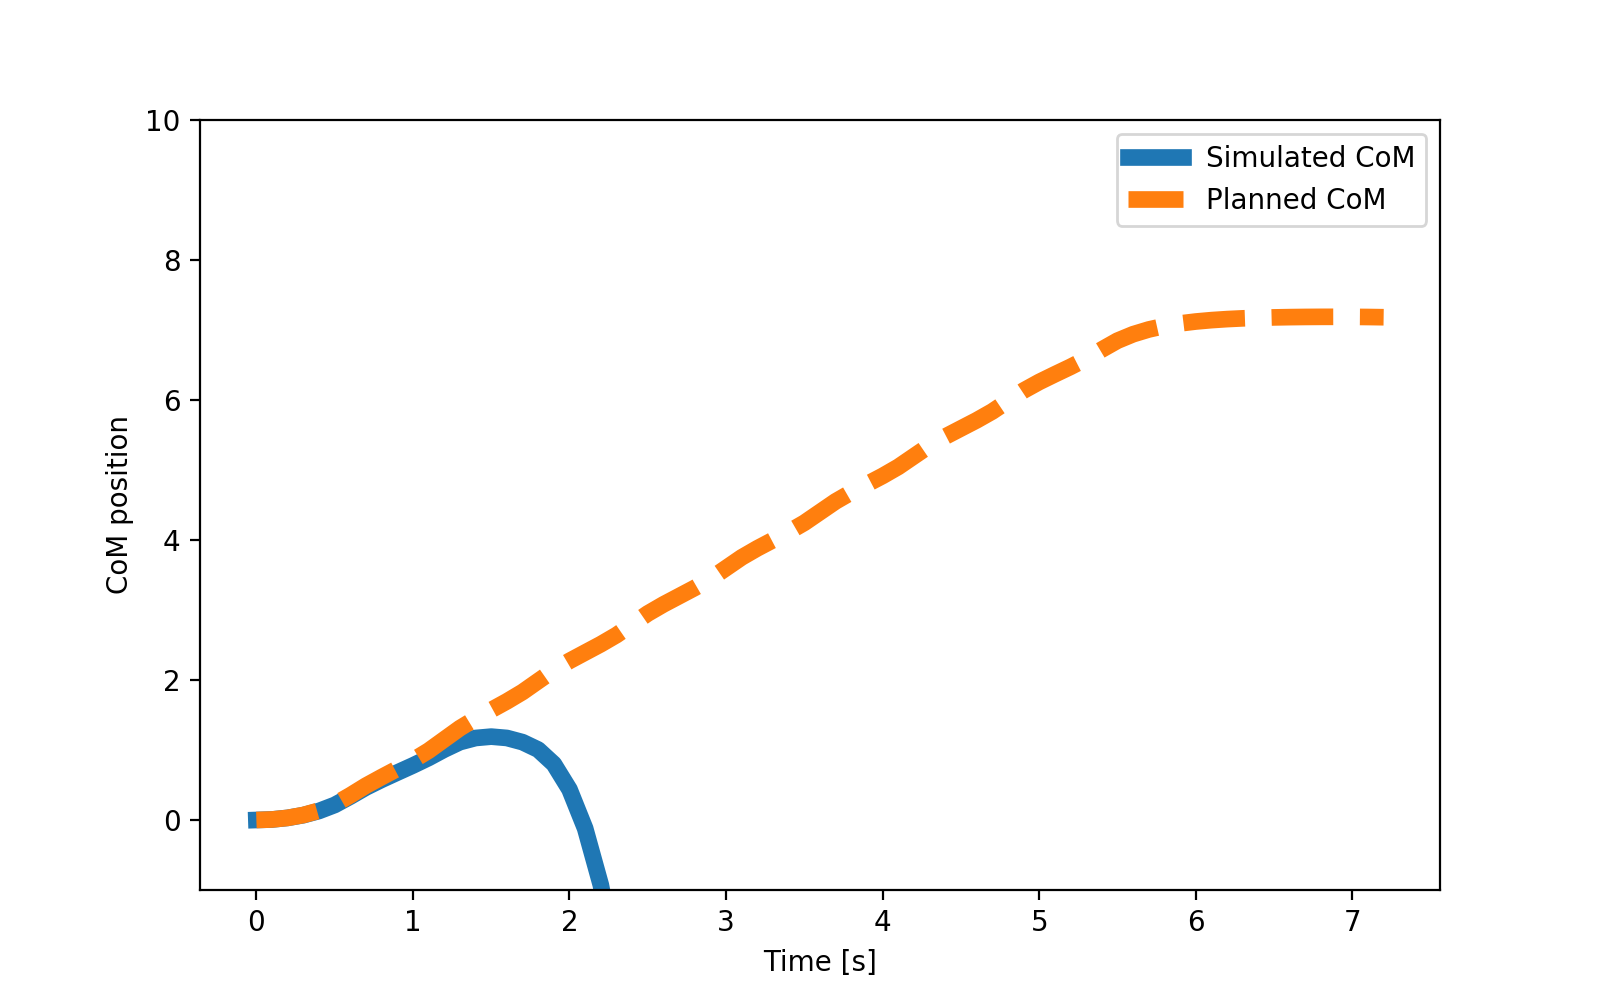

<IPython.core.display.Javascript object>


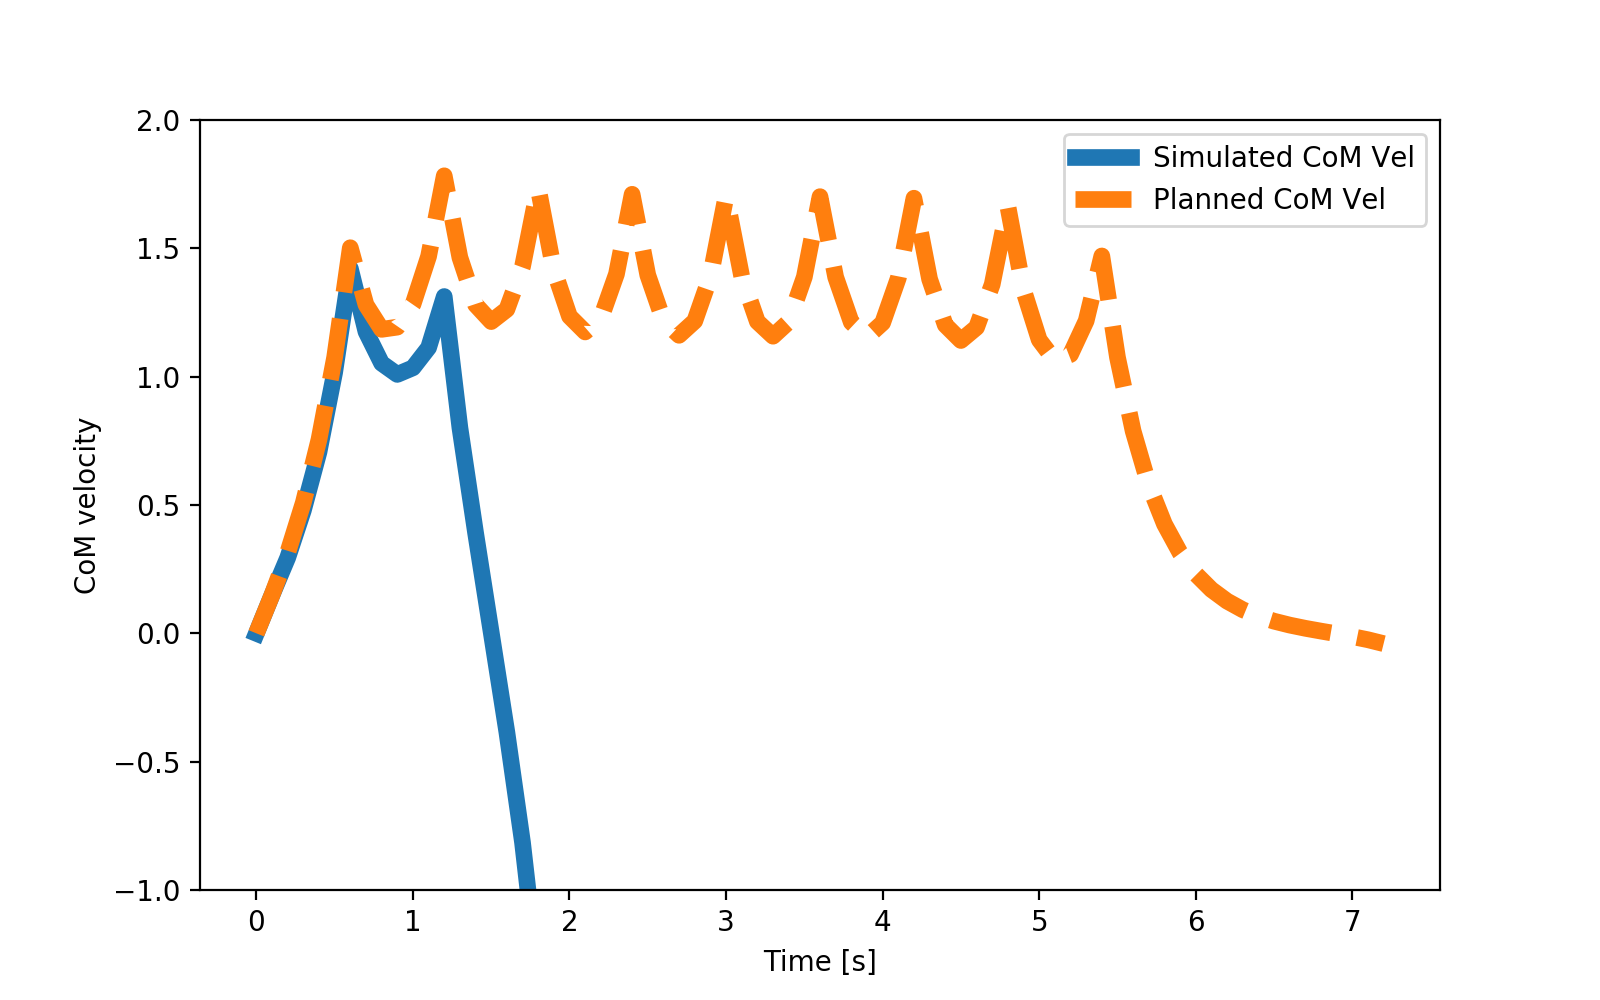

<IPython.core.display.Javascript object>


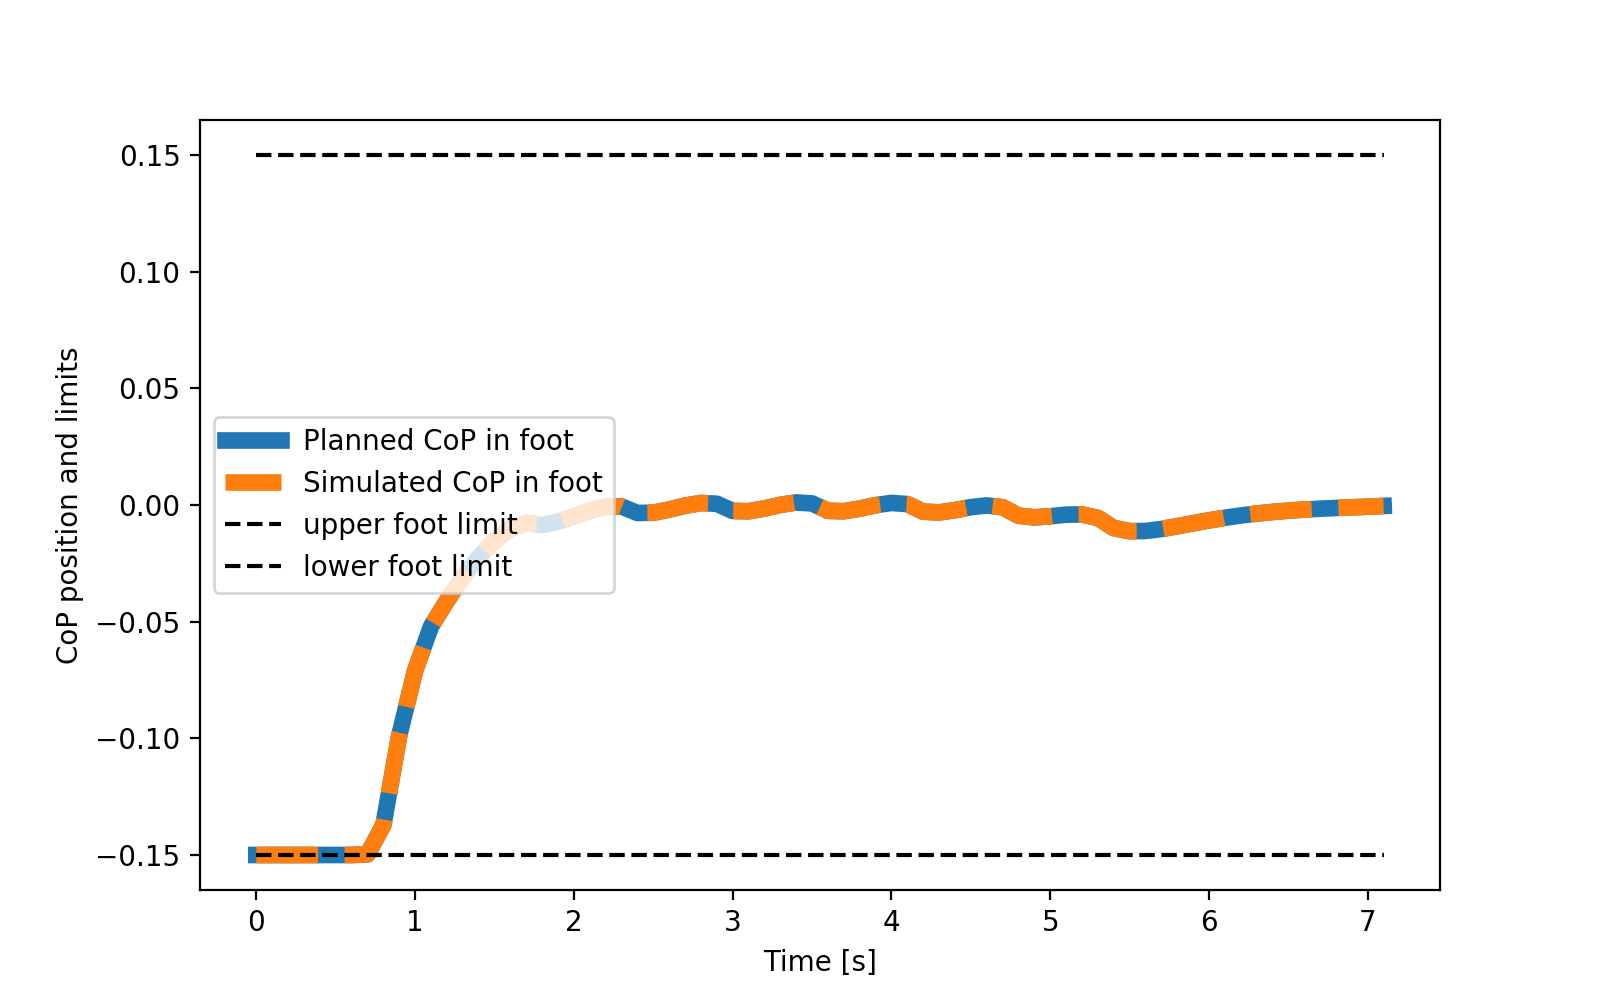

<IPython.core.display.Javascript object>


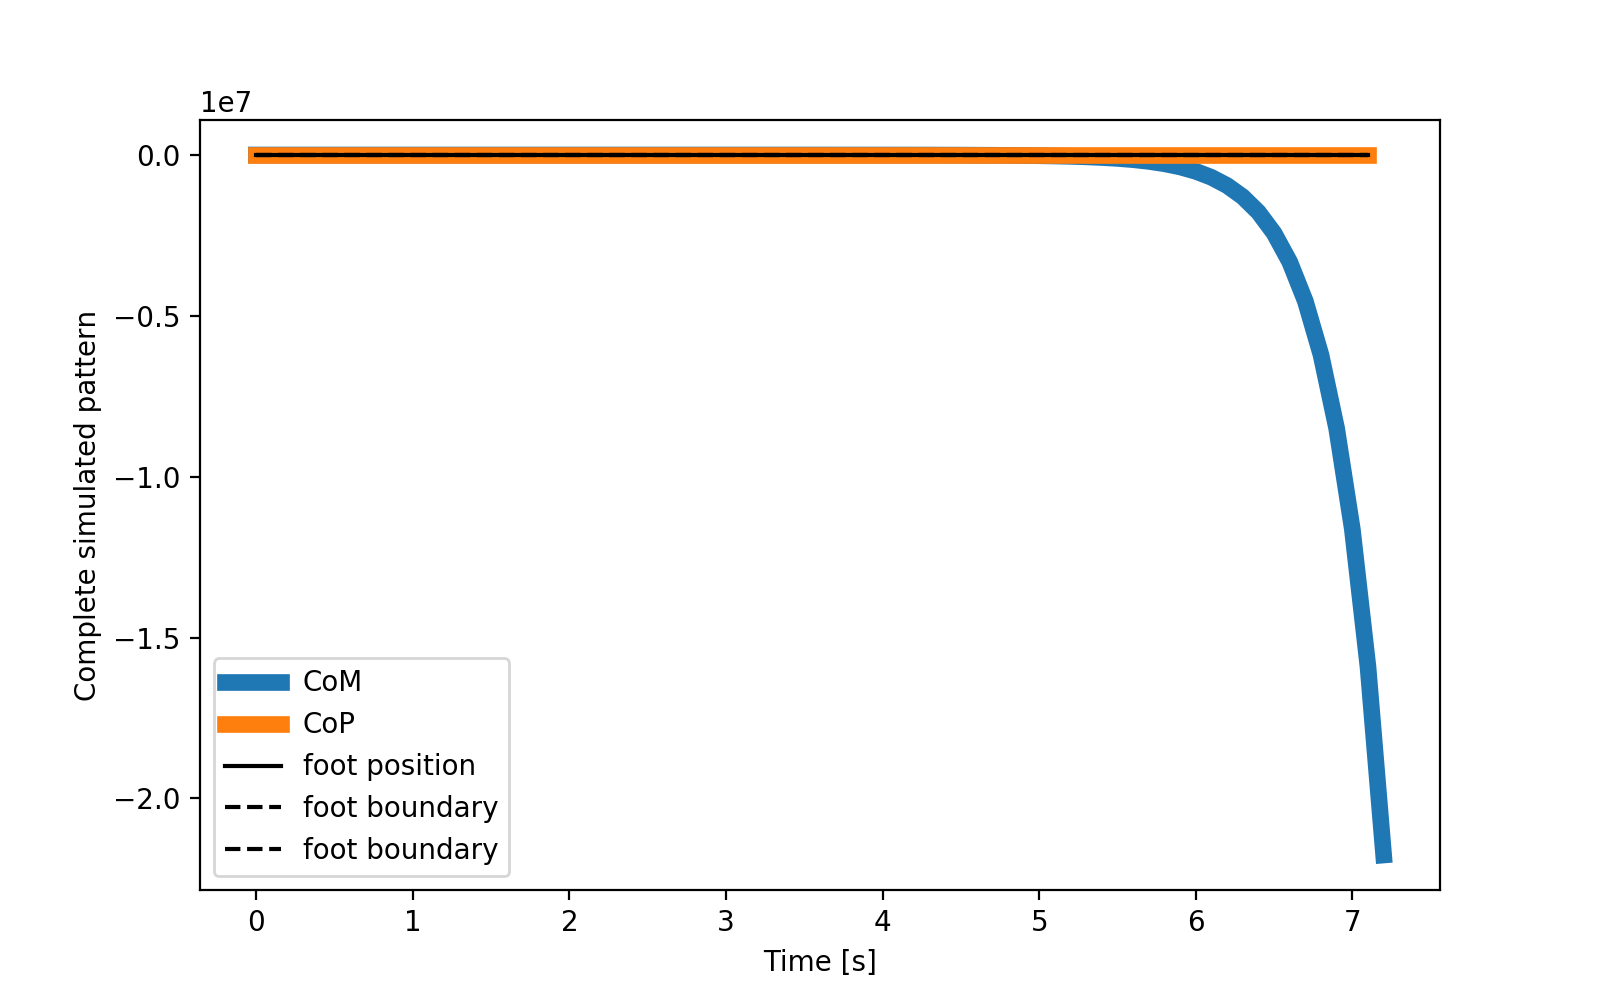

In [23]:
# the planned one with the simulation results 
plot_results(x_real, u_real, x_plan, u_plan)

e)First, we increase both running costs and the terminal cost, we have to increase horizon. This is because we require that the robot move as we plan in prior under noise(distrubance) and deviation from the desired trajectory is costly so more steps have to be considered in advance for securing the desired moving pattern.    
If we only increase the terminal cost, we only need to slightly increase the horizon. First, we think that increasing terminal cost means that being in the right position in the end becomes more important, hence, longer planning horizon is needed for achieving this goal.    

In [40]:
# increase both running cost and terminal cost
plan_length=66
terminal=1e2
running=1e2
walking_model = LIPM()
x66t_real,u66t_real=walking_model.simulate_mpc_terminal(x0,plan_length, horizon_length, foot_position,terminal, running, noise=True)
animate_walker(x66t_real, u66t_real, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABf+21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAyQZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjpW1rX+nre3UiwZAQI9+S8/Rbtc1Uee
ZMiIvTac6Cqb6IQigN+xZv6HX0G1VgZK+kT7deZQiomYYxVX0xC3+iuydoEsMIOX9TlEq7D3Wmsl
LMONJXwFOdCbvLAVQaFokwBUOy8dTs6xjm4iWv90AYu2Szczs+GG01TE7d0QAKjoCSxr+eAKON03
HZFC9DILx/jgUZlHyNi0HHz3hZFoQdk/terB8+AsHm2I7x6gUPQkqGIne0bi+R2QkJ6+YT/D8dsZ
7DabjU1MzGiNTUv6rWFIs5PtN4IQKUioIDxQ1SxACvwqCAwoTkxHa+lTw1OXezRVFEdcc8yRCpN0
byeYrdRpMOUpxNxW9+CHyzg6Ivk34kbxeC94EWCafOjC5dOp9b1kCw7BFdNo08Jdlagq12U//pvH
5ydvOx75vWlJM3ciPUA/bcd4+iV3T5z34KBLkCJ1UGIwAzo4QdyZLoer8yyP2CgtICvz//yOGbw+
wwyrbKSI9kc3yzQ+MBwgKj+UWa4tWdUIzgoo/I2+krsArDrvAJDoa0K1+Xg4Oun/BE5NCvoAxipj
M+i/GoZrZ+6cqifDJkjIdggZyw5f0M74F90/HoFPN1sjZHf+u0Zx8RAKAKjohjqjVGWHOT+BPySY
xqGs8pzoLK1EkB9gCH6N/uXMBSRGiiIpjIak+AlhpkuFKcEOvR4KqYEtYp5bvR4wcGk2MycBKltp
vNlG0+ShhfB0uhexmPq2mFuKj5a+THyE4uTHHGMiBOHqb/D7CROn0he1dBhO05Ysr4/dEKGPITc3
EO8SmmR/cRSnWpyGE6+x7GIM43xZy0gx78vKhUTWIgM12XlVs76g0paYnOZ6w4uMSMtJ3L+nLFlq
h8Ee6Ldz94J/SXA+M/w0+qMKK9r8zhaXde9oyiX3ej57BLy3+4Yz6x88vcYb6tfPl4IxfgrigvKh
QIC07WkQdfT5kKuFbadDhaeD51LSOohWwyl78TtFPCI+Ou8rH0OQGf7L0qGdkp7PI8fPuqhAxNw1
6bLD4ZDqnhfSIK+YWJTeveV79j+jPp+ZSrP1EPwzHFzxQTxoMebz/bFt/28WF1XY+FgxJNvIKMNY
2CiAQye9vhRthyPNOuGwlBw4nv2iYY1n4PBWDphGjD+F/mcNhnVyt7PSwgWxqb8Xz+iqR+f6A93g
tnXf2MtFuMLlm0zNdQWXRgu7+HnK7fzi2yLiC2KoUsycQbUfmLCs5hIo5oK7xiRP+wojgf67LmAb
xei00SdtmjZAxa5yep2wIWsO5PMzcnf1cn6al73Tmon14oKXaYz+TJFznpUSe63fapumt7lJO9Dg
7Ap3L4YbdBFpLlV2rZcKhtRFYq3DyaWe1uROfrCagifpFAPZUFXm9ncUeT/wXJW2pOJZ2HuBOLPt
IpAzfyWbme4bXKZ5ASSLxP0LBEanUDesgksrO0ozMFPG1EIVpUAU7UhNx4Ss03LQe7jJFEfMkGsW
N71mI05uKgBcc3OTZEQsE0wBMrANxqNAXK+ki5DbUpPIRWyAe7EULK9csIk5myxkedSccM23cJ6X
cHRjyRrbnXQqtAoHojSY8yufAI9AMUF8l7UQkF57Et+ywy2I1DA+uR9w66aoxCwzqnX29d2Jc+/J
dS2rXDNn4HrlaEin1cDw/cqMC/VWHf4ctxQ5B7ZXpVtgdpaWrY8NGkBKXhmjIcJ9M3pEfO5kP6Wa
fyr4makZjK8lfjaXUxApSAvH1knzWgjoqnrMMspjq22ESKuG+taGYr78Ull2OZN4BH8wyz3zmwGq
N7G61X5IJsrPYhkRbozJZqkqd6jM0EG3uPqaGJ0ZoRNRmtPjWnCz6qlUFAvFDhMeb0ogCVH6r1t9
ZDeen/IIogXa5JBdFqfSnEOJI+czYaLCZXa8QxSt6bh1IOD/giAVOm7SBTbGlQne6udjIiayRMb8
Ujl+F+EyYf20OjhavAJiEHUGAmEndfR5eMlK90S2pTZBygX0iuhdhfrPXreGDCtMBJABYPaUqzG8
wrNL9ETpcItUQb3pKnnnC4IM2CuJuDZ5GJPGUiMM0v7G6DZ5uSOzLU2GtuAtgA38NuS+t/j0Xbwo
YnB1TCJUmu/AEAeODhuBSNY92vlrcOYTvlKlIAsrF+1NgXloWV1QGmDVJro+A8EuMh+ex2qDfFER
2M/28OwGGkjf/6KTj5v1mDgZ0dbA4zxdq5zlRjwW+wbGyRAwD0acluLftVJ9iT2bCAADGTNdFaj/
AUuovbAvbWkvxY5aghsEhMJ2C+5yctSXlv09NCUBYHmU324ReRyC/ZPsH7ZtrL7FtC+PJBTDjgHd
8Z2diYG31kgeR28c8kar6bJp/cB8jyjc9aeZ880/qyDh4gZ6kJB6LqJSSOIHQlTUZy9WRrfEdZLR
7WRn0GTsafJkrx5aFbn9WUJeiZ6CRHfbKeIB0y64jIWwKdQlChpjgcxBPPOrz3+ft8qr0mzLvnvD
IHbNGi4GPqKuEOym6rWvE7oIdGjHyye6NwNzukH5Nv5cX9itt66uYmp0jzccK/bYFZy/h/wMpVTR
rZgBCgz5OH3PaEBYLPvxo11zOLVorsE6G6nYpWzj9gK1v2iLFD+QwWpzrvVjlGlWryPTqzJjZBCm
68XEHFTHQCj3o4cZSoLSY

<IPython.core.display.Javascript object>


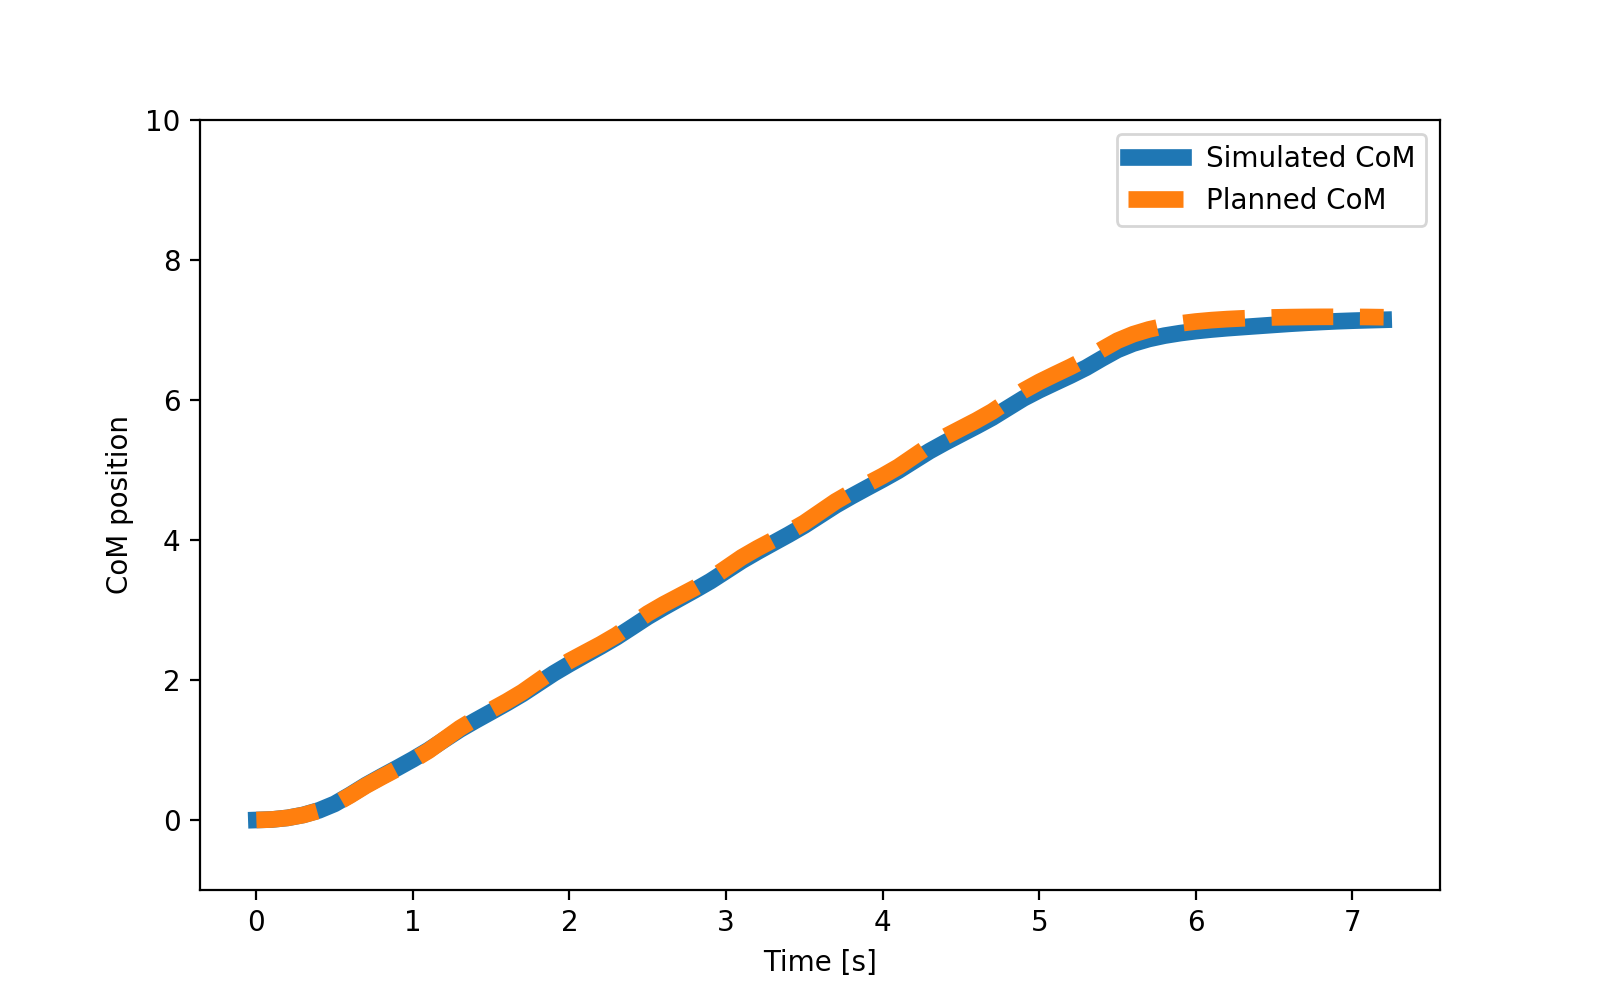

<IPython.core.display.Javascript object>


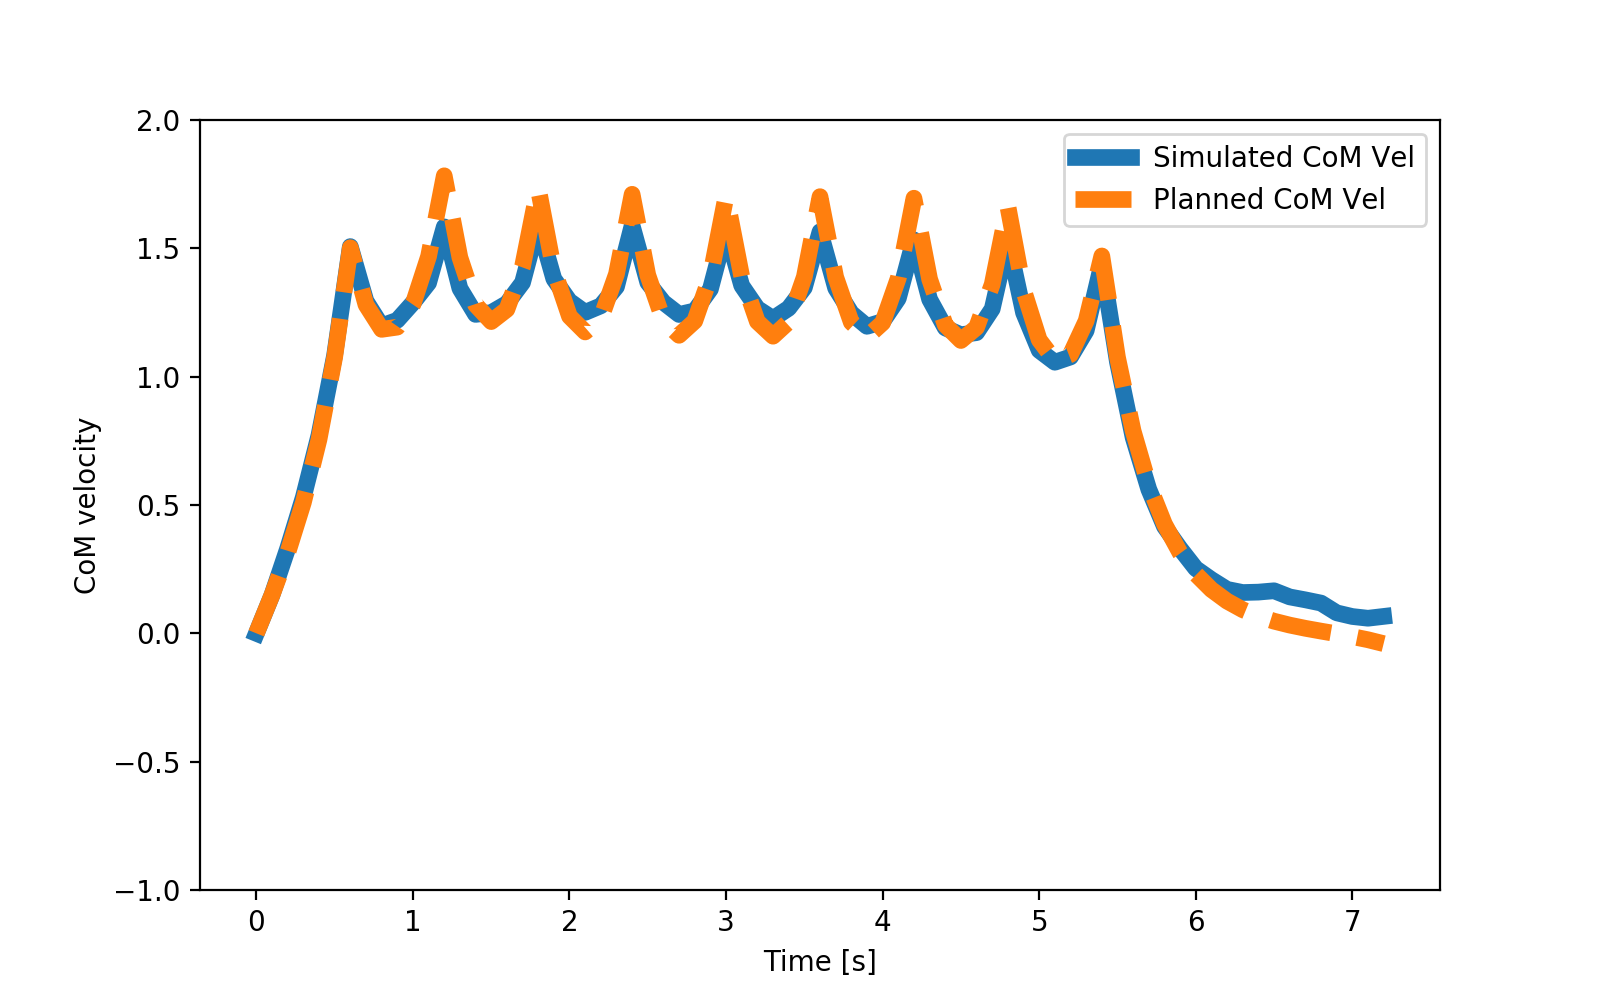

<IPython.core.display.Javascript object>


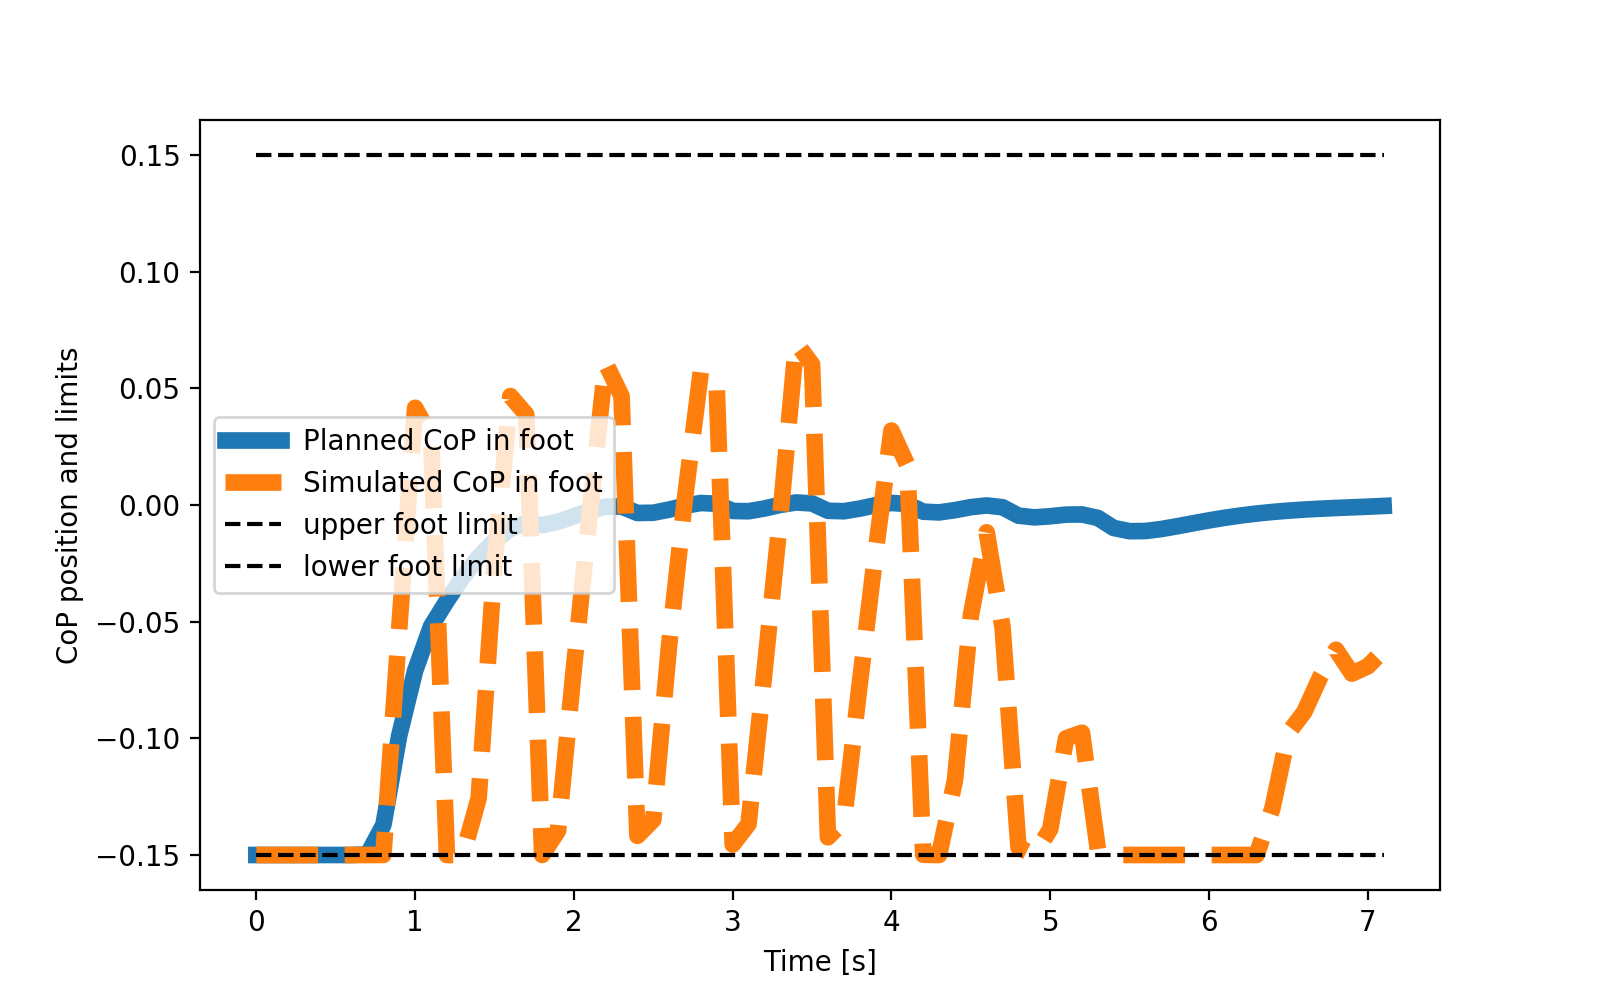

<IPython.core.display.Javascript object>


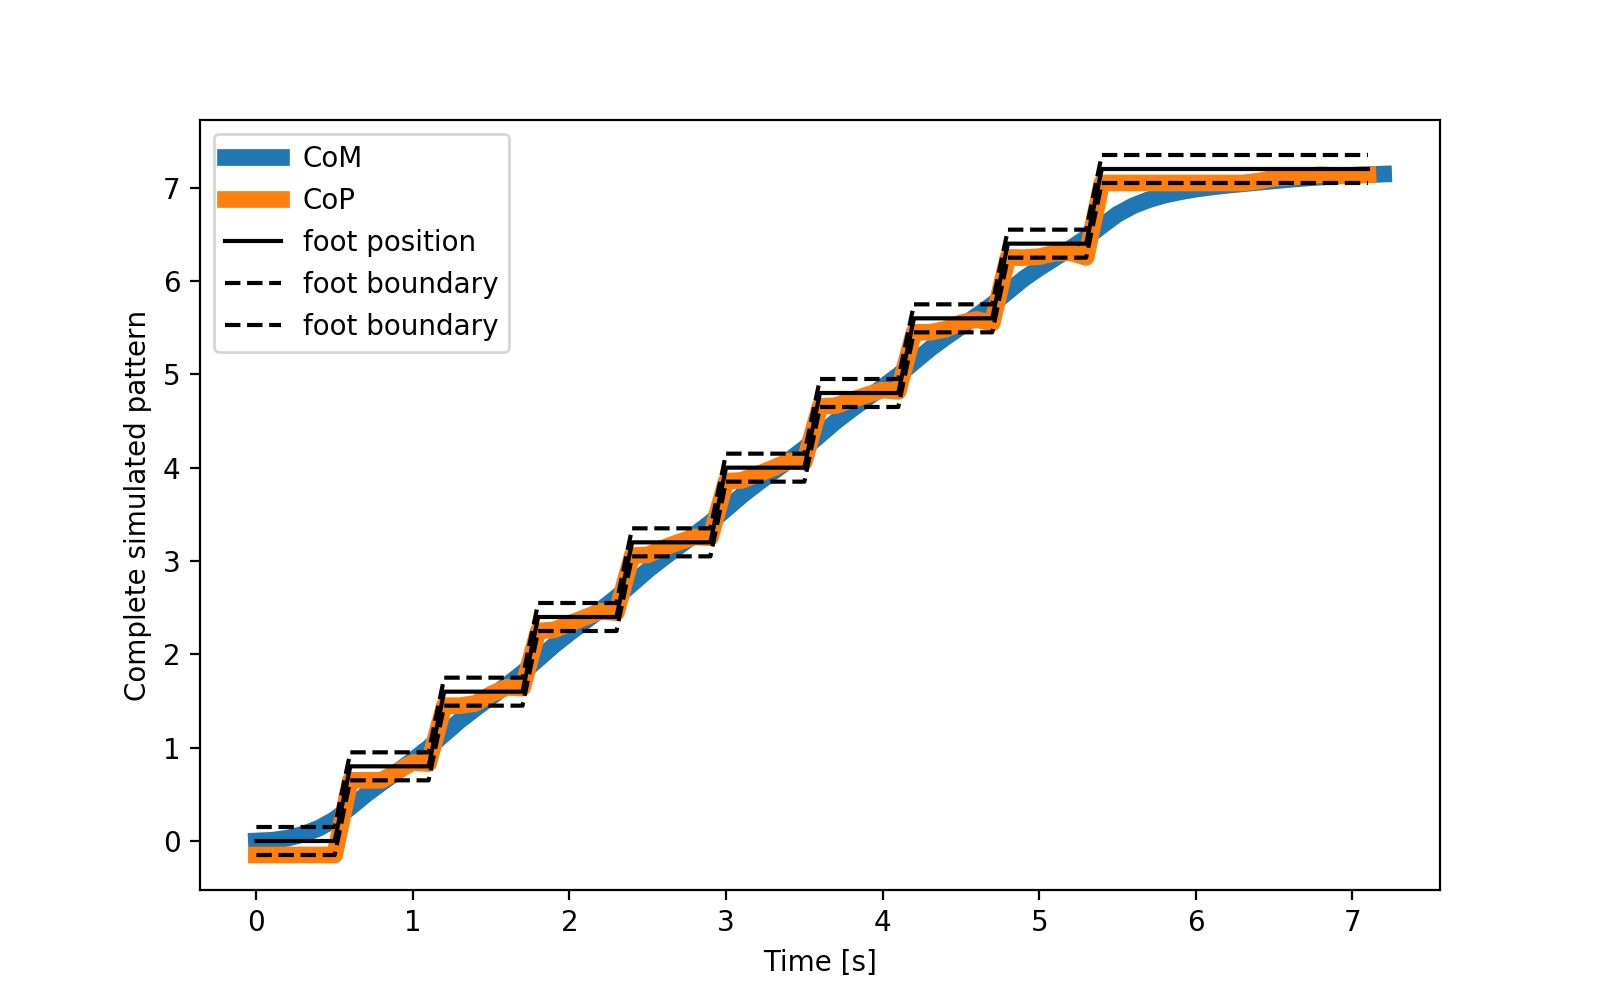

In [41]:
plot_results(x66t_real, u66t_real, x_plan, u_plan)

In [42]:
# only increase the terminal
plan_length=20
terminal=1e9
running=10
walking_model = LIPM()
x20t_real,u20t_real=walking_model.simulate_mpc_terminal(x0,plan_length, horizon_length, foot_position,terminal, running, noise=True)
animate_walker(x20t_real, u20t_real, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABclG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxrZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjpW1rX+nre3UiwZAQI9+S8/Rbtc1Uee
ZMiIvTac6Cqb6IQigN+xZv6HX0G1VgZK+kT7deZQiomYYxVX0xC3+iuydoEsMIOX9TlGXfZwpbNm
/HFM4IXNbvLAVQaC/JTBeuy874HKmEhhJdnRN5XbLHtiZS7vA6dqS3Rsx0Zfg13z4Izin7QAo7S6
IQX7E1gkjUZgBsAdQqcu8ckmxbcsPpziMiXTOyg6Yc8+wBgbviWkdJ4Byj1ljTewSHoyjNAEgMiQ
jSQ6wjBKZJSAIfgRBrEalLVQdQCnhiccMluggMI1AQC25e+i5/L87ZIADuV2JS79riQ9CkuPSmuW
GUTnAin9np7dLdOGx0/i8FuvYXO8CDx/gs+cGo5MH1jSbQSw7D/3R2QuNLCxeA0w1R+RNhnWXyeV
IuOXQod81jdhffd/RDMz5z34JvJ1F1k/AEx7XUxsaHiXxwT3Z1IiDGODX+V/+83pH+a4zGMlsg4I
1gGXhoWr/e8Nycid9lAEuShiAUfkbfBNs/Ak07wCQ6GtkTfGRXVfBwiunNYMrz7MGoz/ZWs1DNcW
v//3z4ZMkZDsE4G7ncGWis1ezuchlWqLhEAXdPH7xYPiIBQBVtD7dUaoxTR6MkOCHpbahrPMZtKW
MiSA+wBFB/PY0Db0pv0Zy1Aj5pkuAj9j/YNVTAlrFPLd6PGUl4TYzJwEqW2m82R6+WlDC+DpfH9j
MfVtMLcVHy18mPkJxcmOOMa0w4xY/7HCRU6AuFS10GE7Tliyv0irI9DkbCW+f05CX3zSJhbilCq7
mGrHrYgzjfFnLSDHvy8qFTnN14zXZeVWJBqDSlpic5nrDjFNIy0ncv6csWWqL8R7ot3P3gn9JdZK
x/DT6oworzPzOFpd172jKJfd8GvsEvLf7hjPrHz3TVBR8z6HgARi4YDIYZ6GVL7OwyXbJy2HInYX
CGKz4ao4hK7WbLnM+/10iLUAWJ6QYKU30awqraUH4o/sWj/P8+su1KW/7FigZI8r/NRfI7Ml7DZD
SVek35AD/iLNvgaDGV2v2Hv/9nghhbzHo2mGdCDX9vU//UYWLefjccIIu4gd93IyopAIZPe3wo2w
0Wd6sswlCFFoeLwoS8amlFc6qnJaP4YN3Hl2B67Cnih0ChFpWo0v9ivd5n4sTIZFlHgrUk3jCQeJ
+87AtDSNnHbxIiy6XrHx0qT65VNwx7eRbsq45xXzkYcoSYor6F2hb5gG8XotNEnU20ughT4Unv52
2UcvlcahxUPArk/SXX+XWCS14mWoPN8I9BiiPcH+1C18yoSPKILWf8wEvgWcvLtsSbSuHDmhqi8+
zic1H/MQRAmNM9rgh8iBxNQMBg93/W+aFGun81dYROvjzHXHAsattWJxyb+JD/vkOckYz8bjiWLe
QMa+oO0Ljn3Th5TrcBmPgyzCbt1uOIwNk8ojTFTjyPEezg2ghiIv3TU3+NOSNurSB8wW7/MeDDjk
U2cAW9pWKOiwFDUU6PcrYaTp47UNdjU0jn/eJRgzK+Owu5St3jOwDz4ecB8qBYWiU9myAvM+KgAB
P3RQpa1PAig3eQX0INQowzZ7en4MtkLGGgt1P1XcQd86YDeAyyW/ufkUjMo4WWulkv9efRfPS3gl
PvIO94UUZ20qhlzDPexWhkmXh4OAlOVVFv6WMm9QX3S+R34/klPE7bM8lcrjOu/iIpYxCCls3ecC
HTpZJsTDLKY6tthEirhvrWhmK+/FhVq7vp41T6Ruky+28Cb6TQn1Zfg6Dlo7HdEsa24ALPb864K8
4KY7X21vKtzuBRsVft/flB18CdaoNq++3FmQR3UNHQEF8SumIHyLlEJT/ADplz3dnudLtetID6Tq
dEeF/5IGcpwu9rUn1w/V+q3/c4/gSnDreH314CK+F9lm/E5e9cvDE4c5u4PZ4+R2H5NNeMNQvkjD
/QlQDZwAygpsLYjGL3YfDxJLsgwIVBqpldwoavCKQGII3GTmixU/eRmTPgrb3xjT4obPnbond6It
dsjFe2mGqSVSu9rMmhkkb4y2CT+hgkm30sOzlYnQCKfZE2HU7iMc/c/wsNGZW2NMadPU4DxKeRPv
JqZK6qlhC31KO9GB644XVt9PbLxz2OaWmqVxX/7P3jQS/lMNnFszZnzJGFS34zUm7LzLM9AxByp4
n9brzHxrZ667gLmu5eX8MDZHyHY7hy69y8ZGLsYVgoWbnz6/PazdKxMtxMuCTN/GyYJ/MawX1S2X
be8ZEaW/8rz/HJ2dJ5fZmpvc/w+wkgAAr8gxj/mn9nas5jxJnTcsHkLrORz8oVnrZ+h5mros7Iar
0HbGyc4u1o0QGIqBwIYLztsb4XR4PmcWNiV3rUtpibu6MK/JyucsmafcCnY8Yr4aXZvF0jIldhiC
B3AOszrSudR+ed+f7MuiDkdEnVvnF0pc1yK4xeKZAjWxxM8+3JZfUjeuxTBdk3/X/5wBTPeF19fi
ReLMfsAkuTbR0DbYduTBqmvJJKO5TeIkPqslQRpOE5JJNtR3v/YQPb0ctUgkiUlj7FK2cf6syT3o
I+YZWmvIVxxzV0ILTSigD3baMrUYaZ8XkUpWCzn2sDpl6DV+31jaBYe9+/eO/xPQsrjJAzA9JtTU
G5+9buO9zpI/LAb3Mb75L

# Exercise 2

a) We first define a function for value iteration. We note that the grid-world includes 4$\times$ 5 and hence, we construct the value function as 4-by-5 2d array. In the numerical implemnetation, we rely on the function one_step_min for computing one-step Bellman backup, which returns $\text{J_min}=\min g(x_n)+J(x_{n+1})$ and the associated optimal control $oc$. Here, different oc values denote different moves (see the following table). Then, in the main function value_iteration, we use this one_step_min to update the value function. We note that in our experiment, in order to simplify the program, we define the cost for the grey cells as $+\infty$, hence the values for these cells are $+\infty$. Accordingly, there is no control for grey cells, however, for consistency, we define the control for these cells as $+\infty$.  

|oc | move|
-----|------
|0| right|
|1|left|
|2|up|
|3|down|
|4|stay|


As we can see from the following experiment, we need 1664 iterations for achieving the convergence and the results are as follows.

In [34]:
# value iteration
def value_iteration(J0,g,alpha, tol, maxit=1e5):
    """
    This function implements value iteration 
    Inputs: 
    J0: initial value function  
    g: cost
    alpha: discounting factor
    tol: tolerance 
    maxit: maximum iteration numbers
    
    Output: optimal value function
    """
    count=0
    # while the #iterations is below the maxit
    while count< maxit:
        e=0
        J1=np.zeros([4,5],dtype=float)
        oc=np.zeros([4,5])
        # value iteration
        for i in range(4):
            for j in range(5):
                # here, we use one_step_min for one step bellman backup
                oc[i,j], J1[i,j] =one_step_min(i,j,J0,g,alpha)
                if J1[i,j]!=np.inf: # for all cells except grey ones, we measure the difference
                    e=e+abs(J1[i,j]-J0[i,j])

        count=count+1
        
        if e<tol:
            break
        else:
            J0=J1
    return oc, J1, count
        
def one_step_min(i,j,J0,g,alpha):
    """
    This function performs one-step bellman backup
    Inputs:
    (i,j): the position of current cell
    J0: current value function
    g: cost
    alpha: discounting factor
    """
    cost=g[i,j]
    # for grey cells where the cost is inf, we return infinity 
    if cost==np.inf:
        return np.inf, np.inf
    # construct five possible movements
    move=np.array([[0,1],[0,-1],[-1,0],[1,0],[0,0]])
    #initialze oc and J_min
    oc=np.inf
    J_min=np.inf
    # for every control:
    for k in range(5):
        u=move[k,:]
        i_new=i+u[0]
        j_new=j+u[1]
        # we first check its validity
        if i_new==-1 or j_new==-1:
            pass
        elif i_new==4 or j_new==5:
            pass
        # if it is a valid control compare its cost-to-go with J_min 
        else: 
            temp=cost+alpha*J0[i_new,j_new]
            if temp<J_min:
                oc=k
                J_min=temp
    return oc, J_min

In [63]:
# value iteration
#cost
g=np.array([[0,0,1,0,-1],[0,np.inf,1,0,10],[0,10,np.inf,1,0],[1,0,0,10,-1]])
# zero initialization
J0=np.zeros([4,5])
J0[1,1]=np.inf
J0[2,2]=np.inf
tol=1e-6
alpha=0.99
oc, J1, count=value_iteration(J0,g,alpha, tol, maxit=1e5)

In [36]:
#optimal control
oc

array([[ 0.,  0.,  0.,  0.,  4.],
       [ 2., inf,  0.,  2.,  2.],
       [ 2.,  1., inf,  0.,  3.],
       [ 2.,  1.,  1.,  0.,  4.]])

In [37]:
#number of iterations
count

1664

In [38]:
# value functions
J1

array([[-95.0795 , -96.03989, -97.00999, -98.99999, -99.99999],
       [-94.1287 ,       inf, -96.02989, -98.00999, -88.99999],
       [-93.18741, -82.25554,       inf, -97.00999, -98.99999],
       [-91.25554, -90.34298, -89.43955, -88.99999, -99.99999]])

b) Policy iteration. For a given policy $\mu$, we have $J_\mu(i,j)=g(i,j)+\alpha J_\mu(i_{new}, j_{new})$, where $(i_{new}, j_{new})$ corresponds to the new state under the policy. This equation leads to the policy evaluation step, and we compute $J_\mu$ by solving $(I-\alpha A)J_\mu=g$, where $A$ is related to the control and indicates what the next state is. Specifically, we give the following functions for performing policy iteration. We first define function control_matrix for construting $A$ with the given control and in this part, we always label these cells in the following way.


| column0  |  column1 |  column2 | column3  | column4  |
|----|:--:|---:|----|----|
| 0  |  1 |  2 | 3  | 4  |
| 5  |  6 |  7 | 8  | 9  |
| 10 | 11 | 12 | 13 | 14 |
| 15 | 16 | 17 | 18 | 19 |

Then, we define the policy_iteration, where we first construct the matix $A$ based on the current control then by solving the linear function, we obtain the policy evaluation, based on which we futher perform the policy improvment.  

In our experiment, we first show that if we start with the optimal control obtained from value iteration, our policy iteration returns the optimal control instantly, which in some sense verifies the validity of our program. Then, we find that 8 iterations is needed for reaching the same optimal policy, if we start with the given initial control in the question. However, the value function is slightly different from the one obtained by value iteration, since we deal with the linear system in policy evaluation, which is not a iterative scheme as the one used above.  

In [39]:
def control_matrix(control):
    # initialize A
    N=np.size(control)
    A=np.zeros([N,N])
    row=np.size(control,0)
    col=np.size(control,1)
    # each row of move corresponds to a kind of movement in teh grid 
    move=np.array([[0,1],[0,-1],[-1,0],[1,0],[0,0]])
    for i in range(row):
        for j in range(col):
            u=control[i,j]
            index=i*col+j
            # for grey cells, define A[k,k]=1
            if u==np.inf:
                i_new=i
                j_new=j
            else: 
            #for other cells, A[k,k'] indicates where the next state is 
                u=int(u)
                delta=move[u,:]
                i_new=i+delta[0]
                j_new=j+delta[1]
                
            index_new=i_new*col+j_new  
            A[index,index_new]=1
    
    return A
            

In [72]:
# policy iteration. We note that in our definition of cost, there are two np.inf for grey cells. 
# When solving the linear system, we replace np.inf with zero, which does not affect other values
def policy_iteration(g,u0,alpha,maxit=1e6):
    row=np.size(u0,0)
    col=np.size(u0,1)
    count=0
    g_bar=np.copy(g)
    g_bar[g_bar==np.inf]=0
    while count<maxit:
    # policy evaluation
        A=control_matrix(u0)
        rhs=np.reshape(g_bar,row*col)
        n=np.size(A,0)
        M=np.eye(n)-alpha*A
        J=np.linalg.solve(M,rhs)
    # policy improvement
        J=np.reshape(J,(row,col))
        u=np.zeros([4,5])
        for i in range(row):
            for j in range(col):
                # bellman backup
                u[i,j],_=one_step_min(i,j,J,g,alpha)
        #print(u)
        count=count+1
        if (u==u0).all():
            break
        else: u0=u
    # value for the grey cell
    
    J[1,1]=np.inf
    J[2,2]=np.inf
    return u, J, count
        

In [73]:
# verifying our policy iteration algorithm
u0=oc
u,_,count_oc=policy_iteration(g,u0,alpha)

In [74]:
oc==u

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [75]:
count_oc

1

In [76]:
# start with the initialization given in the question
u0=4*np.ones([4,5])
u0[1,1]=np.inf
u0[2,2]=np.inf
u0

array([[ 4.,  4.,  4.,  4.,  4.],
       [ 4., inf,  4.,  4.,  4.],
       [ 4.,  4., inf,  4.,  4.],
       [ 4.,  4.,  4.,  4.,  4.]])

In [77]:
oc_p,J_p,count_p=policy_iteration(g,u0,alpha)

In [78]:
# optimal control
oc_p

array([[ 0.,  0.,  0.,  0.,  4.],
       [ 2., inf,  0.,  2.,  2.],
       [ 2.,  1., inf,  0.,  3.],
       [ 2.,  1.,  1.,  0.,  4.]])

In [79]:
# number of iterations
count_p

8

In [80]:
# optimal value functions
J_p

array([[ -95.0795 ,  -96.0399 ,  -97.01   ,  -99.     , -100.     ],
       [ -94.12871,        inf,  -96.0299 ,  -98.01   ,  -89.     ],
       [ -93.18742,  -82.25554,        inf,  -97.01   ,  -99.     ],
       [ -91.25554,  -90.34299,  -89.43956,  -89.     , -100.     ]])

c) As shown below, two methods return the same optimal control, whereas the value functions are slightly different, and as we discussed before, we think this is due to the fact that we do not use iterative scheme for evaluating the policy value function. On the other hand, we notice that in this example, policy iteration only need 8 iterations before reaching the optimal one, while value iteration needs 1664, which seems to prove that policy iteration is more efficient. On a second thought, we note that the worst possible case for policy iteration is that it may take $5^{18}$ iterations before achieving optimality, i.e, it may run over every possible policy in this gird world. The only thing we are certain is that policy iteration is bound to stop in finite time.    

In [57]:
oc==oc_p

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [68]:
# we evaluate the difference between two 
J_v=np.copy(J1)
J_v[1,1]=0
J_v[2,2]=0
np.linalg.norm(J_v-J_p)

2.3152615969935822e-05